In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import normalize

In [2]:
from numpy.random import seed
seed(1)

# Data

We want a lognormal distribution, but we also want to vectorize the data samples. This is to mimic the situtation we eventually want to consider, which is the qGANs architecture. In the qGAN architecture, we are going to have  2𝑛  values to work with (with n being the number of qubits), so we model the target distribution by establishing bins for each value to go into. Here, the binning process is simple, where we put values into bins linearly from 0 - 15, where the last bin contains all the values beyond 15 (hence the small peak at the end).

In [3]:
# Number training data samples
N = 10000000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

In [4]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

In [5]:
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([1585646., 2209953., 1597579., 1110402.,  785608.,  569253.,
         420606.,  319634.,  245427.,  192927.,  153160.,  123008.,
          99929.,   81866.,   67693.,  437309.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

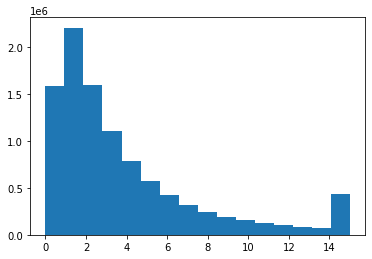

In [6]:
plt.hist(bin_indices, bins = 16)

In [7]:
data_temp

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [8]:
np.sum(data_temp[100:200], axis = 0)/100

array([0.13, 0.12, 0.21, 0.12, 0.12, 0.06, 0.07, 0.03, 0.03, 0.04, 0.01,
       0.  , 0.  , 0.01, 0.  , 0.05])

In [9]:
data_process = []
for i in range(int(N/1000)):
    new_point = np.sum(data_temp[i*1000:(i+1)*1000], axis = 0)/1000
    data_process.append(new_point)
data_processed = np.array(data_process)

In [10]:
BATCH_SIZE = 100
data_loader = DataLoader(data_processed, batch_size=BATCH_SIZE, shuffle=True)

# Networks

Simple classical discriminator

## Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator

Here we define how many qubits, and the depth of the variational circuit

In [12]:
n_qubits = 4
# size = 100
q_depth = 2

In [13]:
dev = qml.device("default.qubit", wires= n_qubits)

Here we define how the variational circuit looks like.

We use all three rotations here, as well as circular entanglement with CNOTs.

Finally, the measurement gives us the probability of each possible 16 values (since it is a simulator, it will be the perfect one).

In [14]:
@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    #qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    
    # Init distribution
    #for a in range(n_qubits):
    #    qml.Hadamard(wires=a)
    
    # Actual distribution
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RX(weights[3*(i*n_qubits + j)], wires=j)
            qml.RY(weights[3*(i*n_qubits + j) + 1], wires=j)
            qml.RZ(weights[3*(i*n_qubits + j) + 2], wires=j)
            if (j == (n_qubits - 1)):
                qml.CNOT(wires=[j,0])
            else:
                qml.CNOT(wires=[j,j+1])
    
    for k in range(n_qubits):
        qml.RX(weights[(3*q_depth * n_qubits) + k], wires=k)
        qml.RY(weights[(3*q_depth * n_qubits) + k + 1], wires=k)
        qml.RZ(weights[(3*q_depth * n_qubits) + k + 2], wires=k)
    
    
    return qml.probs(wires=range(n_qubits))

In [15]:
weight_shapes = {"weights": (3*(q_depth +1) * n_qubits, 1)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=16)

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(qlayer)

    return model

In [17]:
generator = make_generator_model()


In [18]:
discriminator = make_discriminator_model()

In [19]:
noise = tf.random.normal([100, 4])

In [20]:
generator(noise)

<tf.Tensor: shape=(100, 16), dtype=float64, numpy=
array([[0.77938817, 0.00774452, 0.01014346, ..., 0.01512738, 0.00527865,
        0.03996278],
       [0.77938817, 0.00774452, 0.01014346, ..., 0.01512738, 0.00527865,
        0.03996278],
       [0.77938817, 0.00774452, 0.01014346, ..., 0.01512738, 0.00527865,
        0.03996278],
       ...,
       [0.77938817, 0.00774452, 0.01014346, ..., 0.01512738, 0.00527865,
        0.03996278],
       [0.77938817, 0.00774452, 0.01014346, ..., 0.01512738, 0.00527865,
        0.03996278],
       [0.77938817, 0.00774452, 0.01014346, ..., 0.01512738, 0.00527865,
        0.03996278]])>

# Cost function

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

# Training

In [25]:
EPOCHS = 200
noise_dim = n_qubits
num_examples_to_generate = 100
#BUFFER_SIZE = 60000


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        test_data = generator(seed, training=False).numpy()
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        y = range(16)
        ax.bar(y, test_data[0] )
        plt.show()
        
        for n_batch, batch in enumerate(dataset):
            X_batch = tf.convert_to_tensor(batch.numpy())
            train_step(X_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

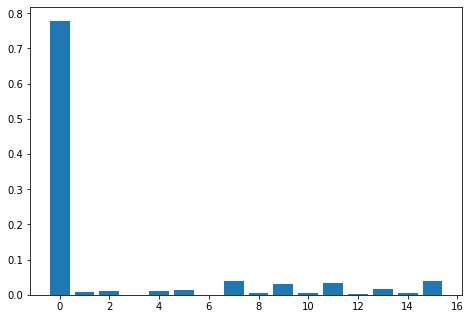

Time for epoch 1 is 650.5018615722656 sec


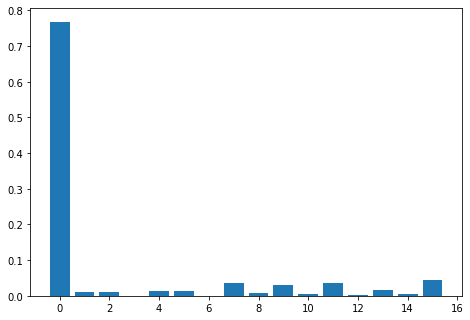

Time for epoch 2 is 9.792420148849487 sec


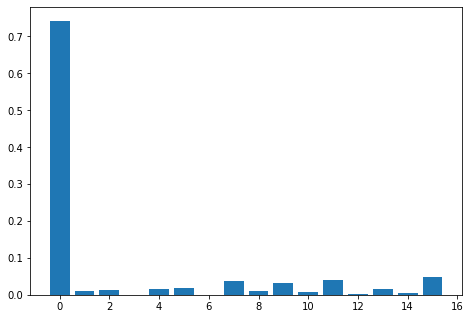

Time for epoch 3 is 10.251603841781616 sec


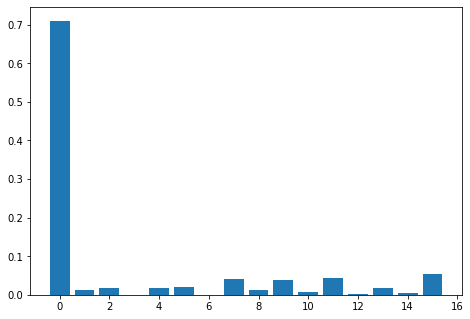

Time for epoch 4 is 10.174472332000732 sec


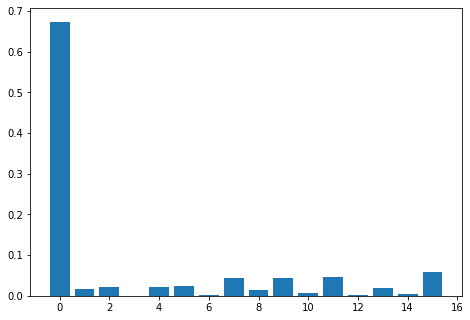

Time for epoch 5 is 10.11465859413147 sec


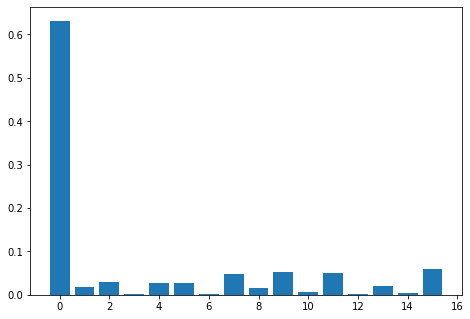

Time for epoch 6 is 10.118005990982056 sec


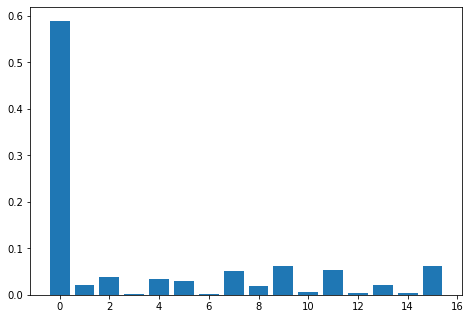

Time for epoch 7 is 10.08087944984436 sec


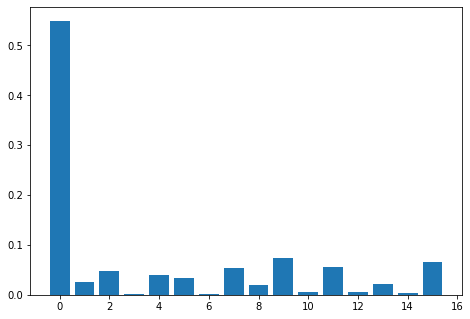

Time for epoch 8 is 10.11012578010559 sec


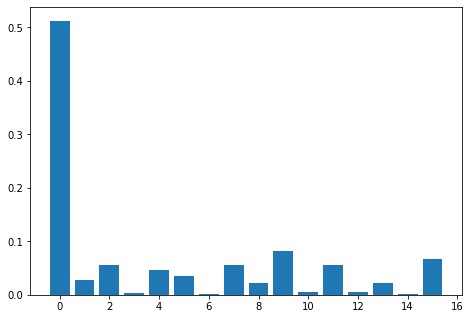

Time for epoch 9 is 17.615747451782227 sec


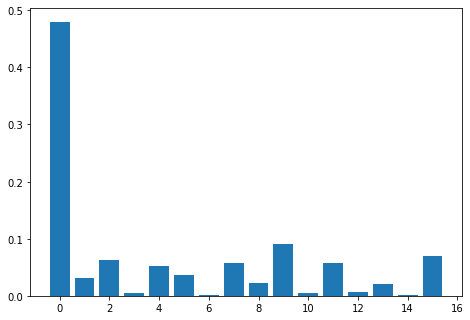

Time for epoch 10 is 10.05003571510315 sec


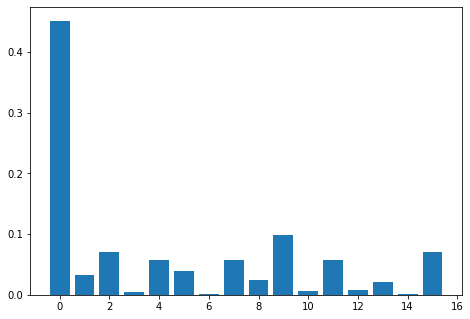

Time for epoch 11 is 9.838743925094604 sec


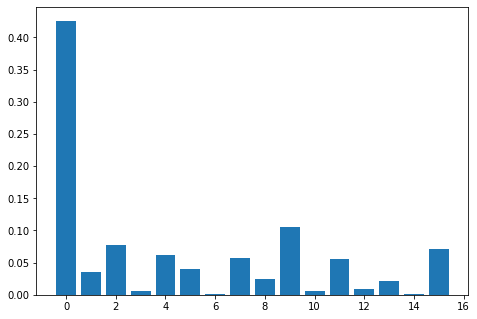

Time for epoch 12 is 9.875033378601074 sec


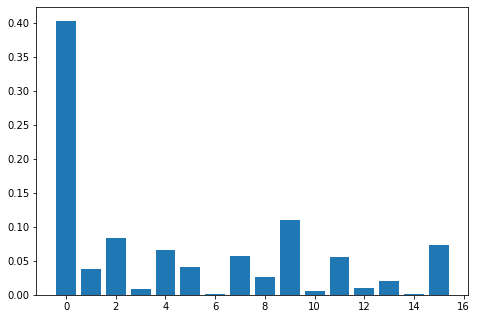

Time for epoch 13 is 10.056475162506104 sec


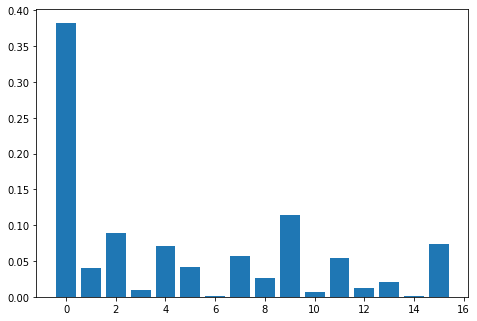

Time for epoch 14 is 9.968663215637207 sec


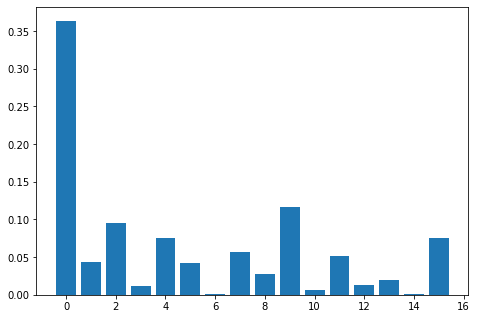

Time for epoch 15 is 9.968440294265747 sec


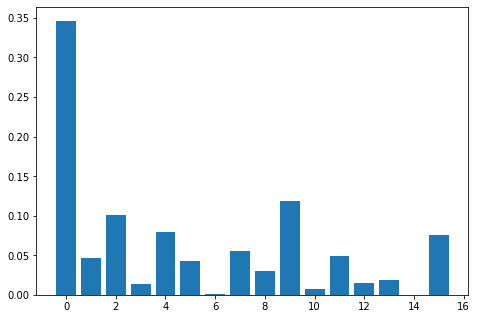

Time for epoch 16 is 9.983126163482666 sec


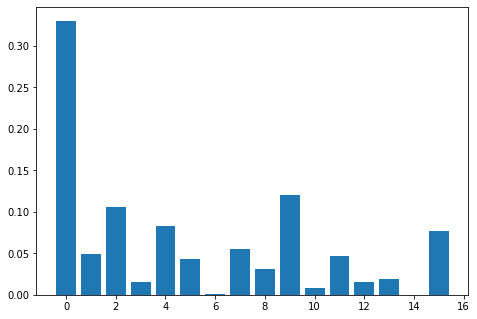

Time for epoch 17 is 9.883837699890137 sec


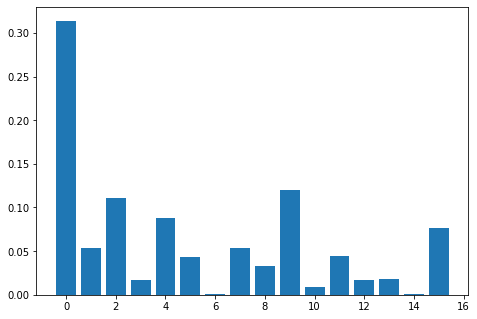

Time for epoch 18 is 9.99350881576538 sec


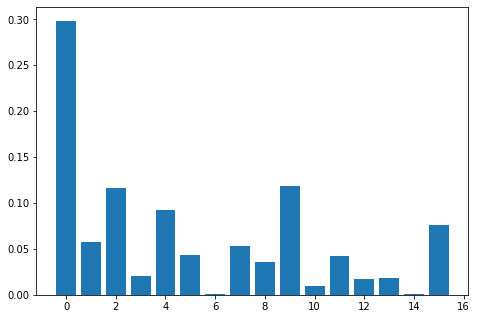

Time for epoch 19 is 9.715790510177612 sec


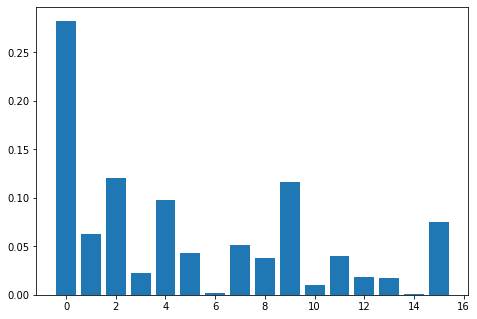

Time for epoch 20 is 9.794237852096558 sec


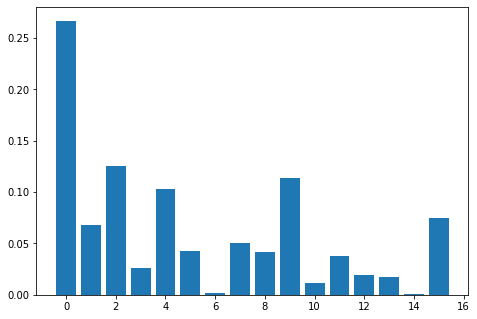

Time for epoch 21 is 9.987599611282349 sec


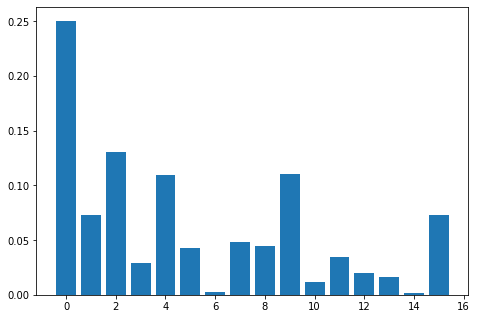

Time for epoch 22 is 9.942351341247559 sec


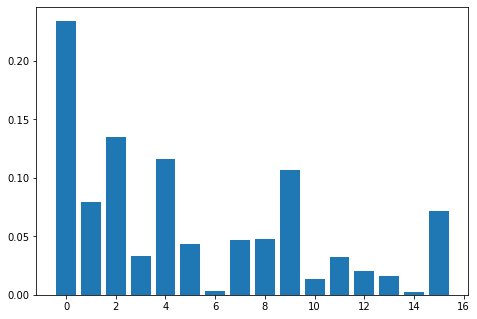

Time for epoch 23 is 10.069326877593994 sec


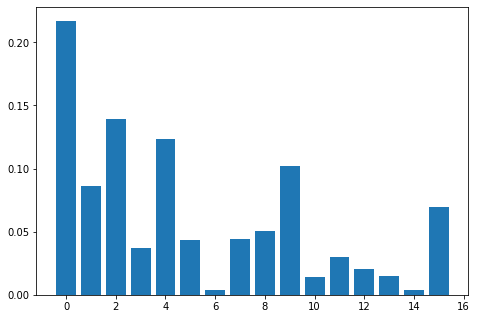

Time for epoch 24 is 9.917830228805542 sec


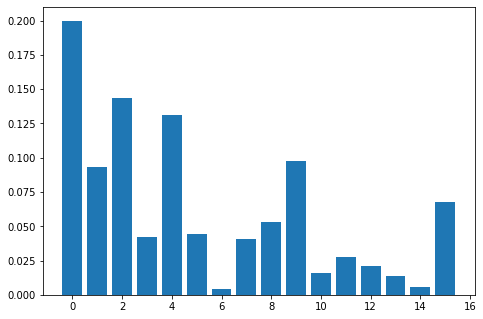

Time for epoch 25 is 10.043472290039062 sec


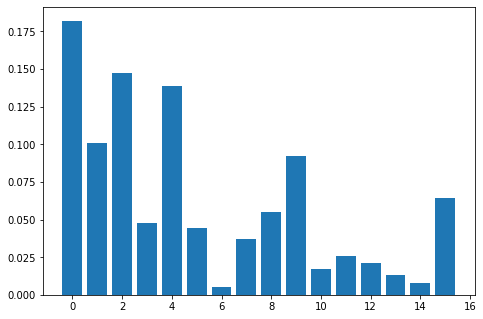

Time for epoch 26 is 10.106909036636353 sec


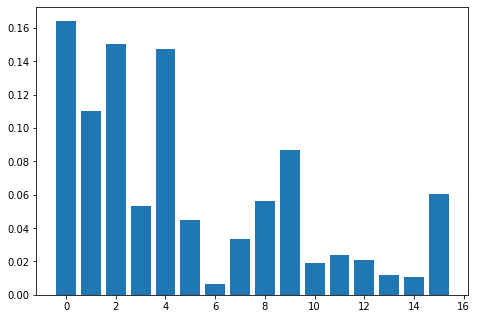

Time for epoch 27 is 10.204566240310669 sec


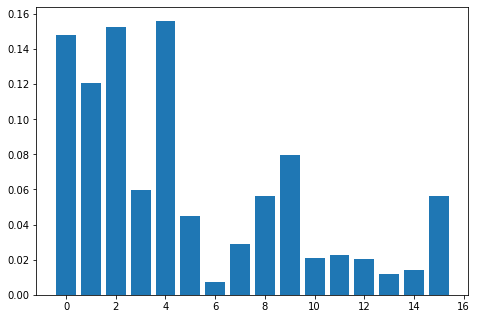

Time for epoch 28 is 9.95759630203247 sec


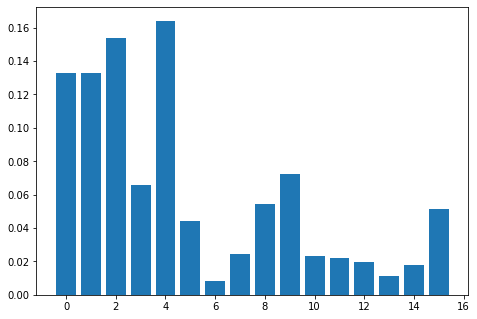

Time for epoch 29 is 10.193547010421753 sec


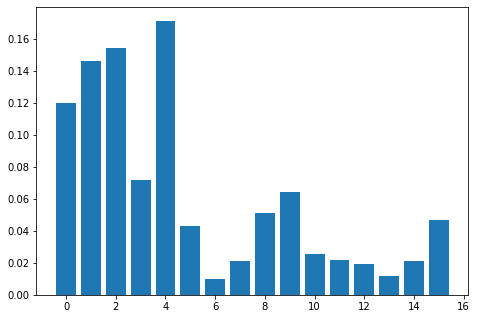

Time for epoch 30 is 10.396510362625122 sec


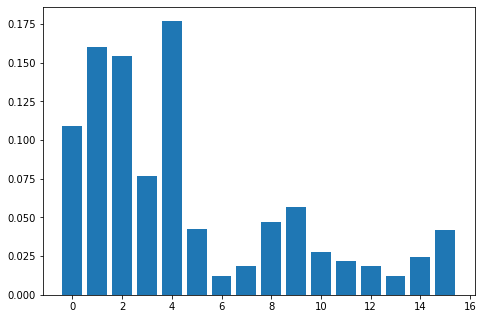

Time for epoch 31 is 10.13379168510437 sec


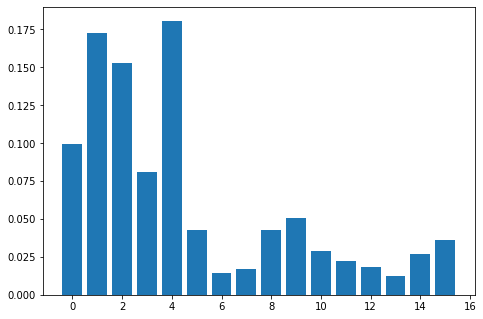

Time for epoch 32 is 10.078124046325684 sec


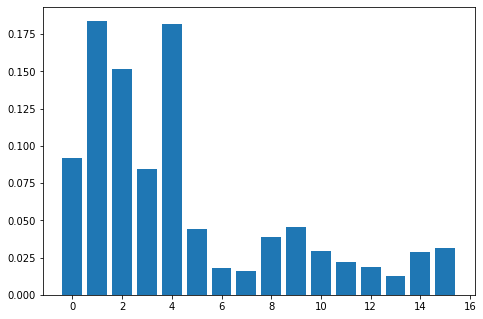

Time for epoch 33 is 9.943351030349731 sec


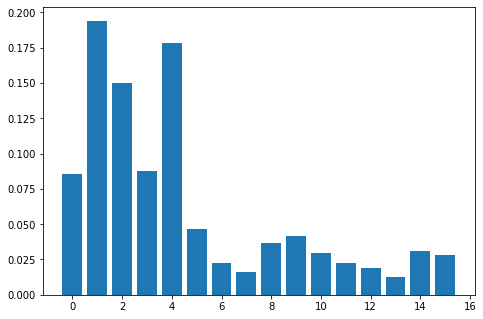

Time for epoch 34 is 9.898171424865723 sec


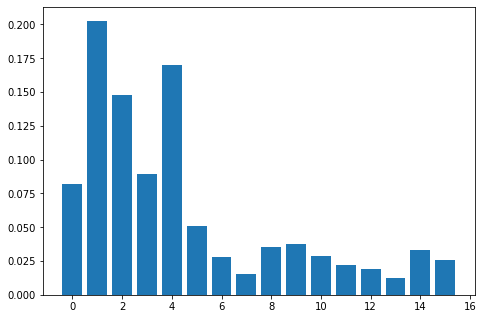

Time for epoch 35 is 9.97510552406311 sec


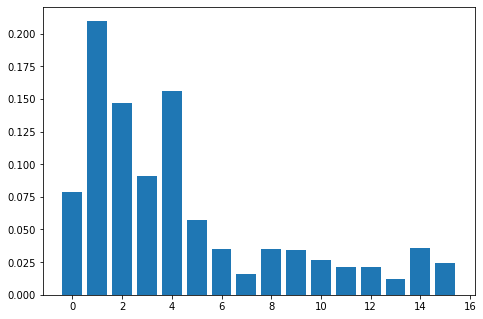

Time for epoch 36 is 9.948394060134888 sec


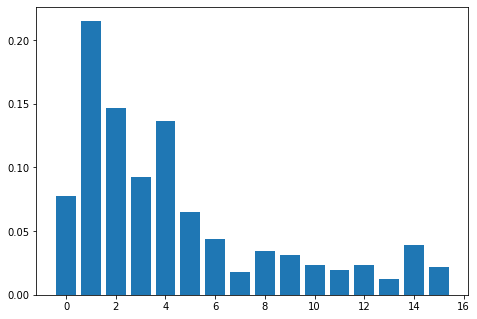

Time for epoch 37 is 9.937309980392456 sec


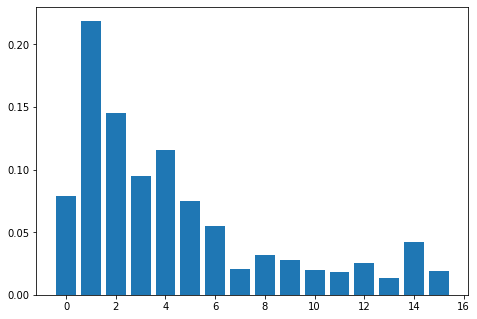

Time for epoch 38 is 9.781677722930908 sec


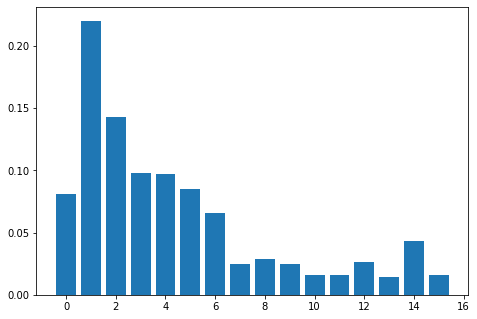

Time for epoch 39 is 9.832123756408691 sec


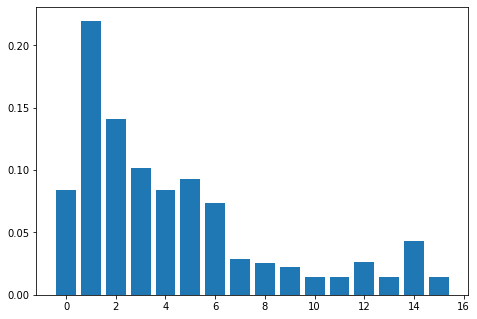

Time for epoch 40 is 9.806323528289795 sec


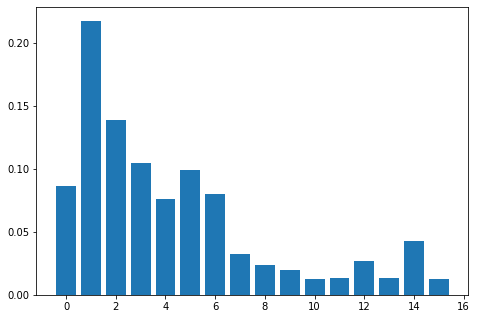

Time for epoch 41 is 9.80933952331543 sec


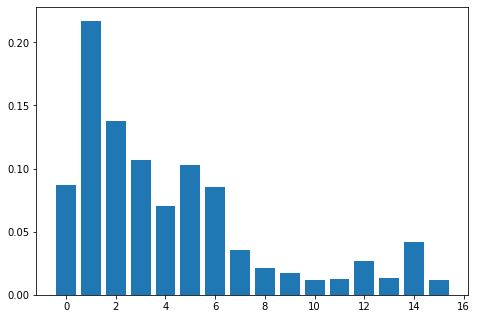

Time for epoch 42 is 9.81990361213684 sec


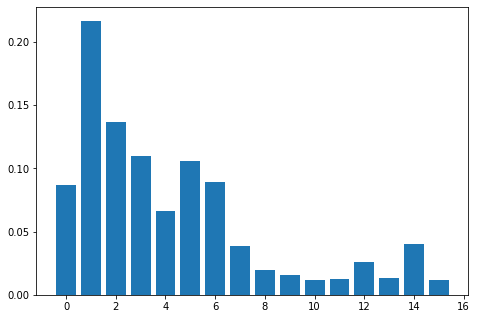

Time for epoch 43 is 9.733623504638672 sec


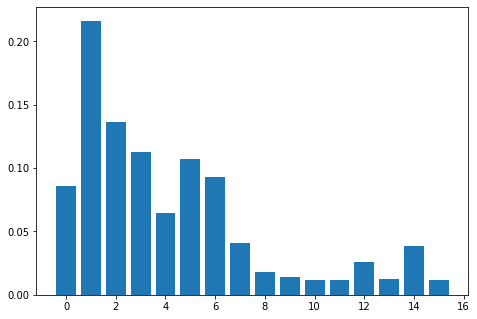

Time for epoch 44 is 9.9385826587677 sec


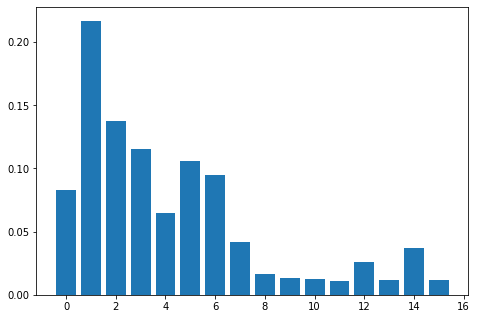

Time for epoch 45 is 9.961037397384644 sec


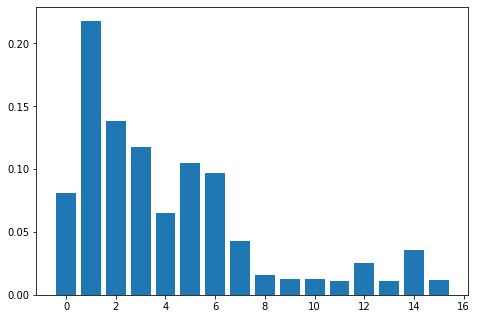

Time for epoch 46 is 9.851314306259155 sec


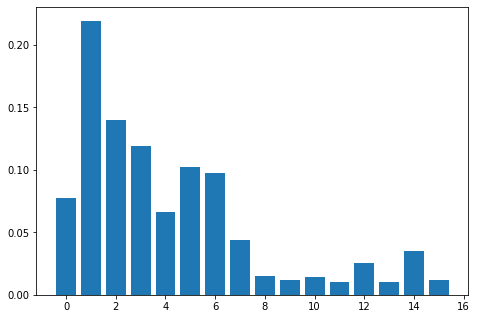

Time for epoch 47 is 10.044547319412231 sec


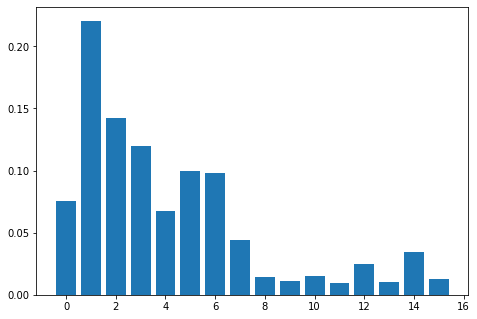

Time for epoch 48 is 9.795594215393066 sec


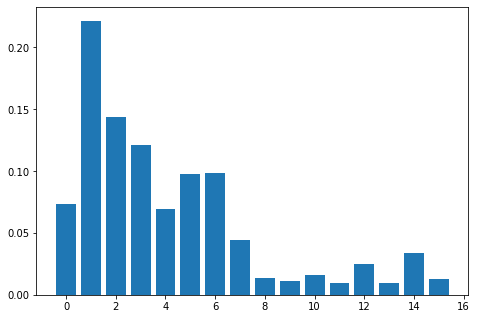

Time for epoch 49 is 9.87492299079895 sec


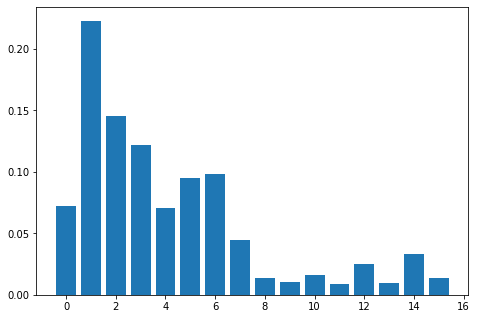

Time for epoch 50 is 9.912671566009521 sec


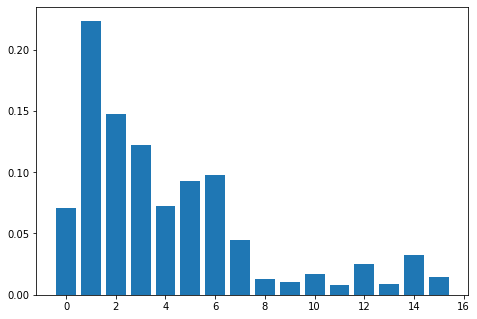

Time for epoch 51 is 9.835295915603638 sec


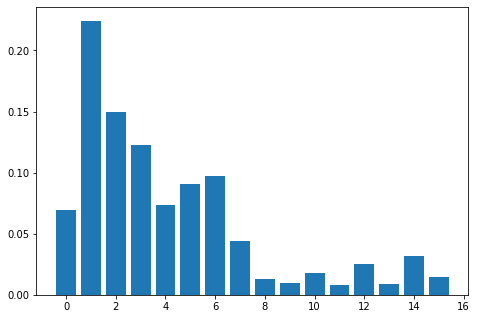

Time for epoch 52 is 9.798256635665894 sec


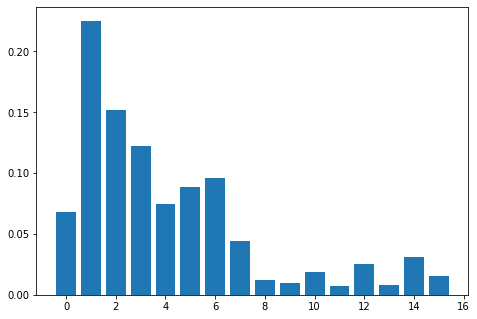

Time for epoch 53 is 9.80504560470581 sec


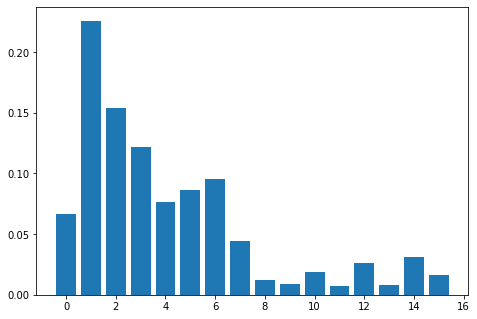

Time for epoch 54 is 9.79751992225647 sec


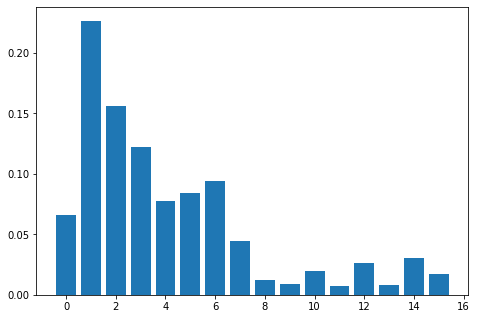

Time for epoch 55 is 9.776927709579468 sec


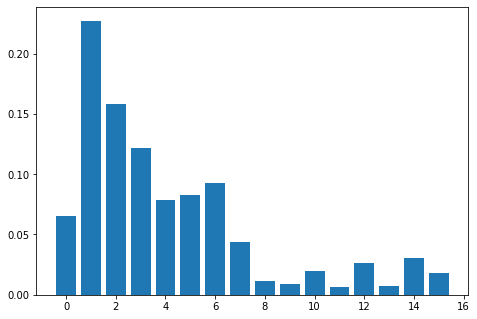

Time for epoch 56 is 9.725916385650635 sec


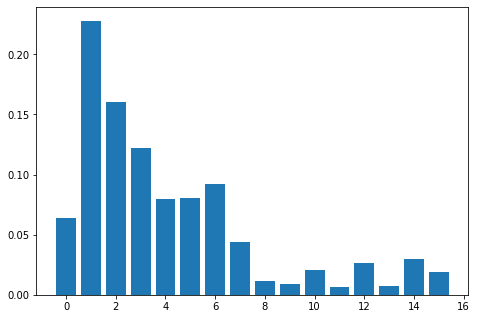

Time for epoch 57 is 9.752862691879272 sec


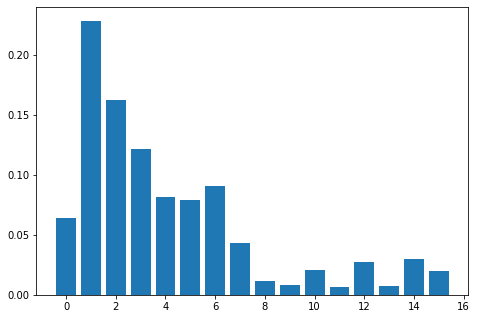

Time for epoch 58 is 9.908462047576904 sec


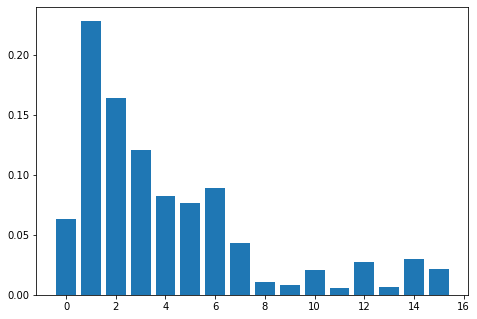

Time for epoch 59 is 9.83907675743103 sec


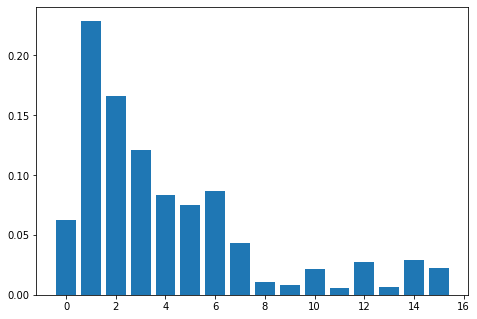

Time for epoch 60 is 9.829910278320312 sec


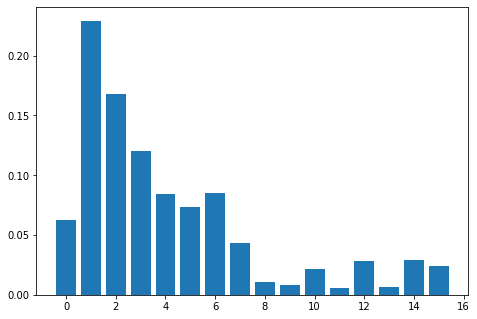

Time for epoch 61 is 9.731224060058594 sec


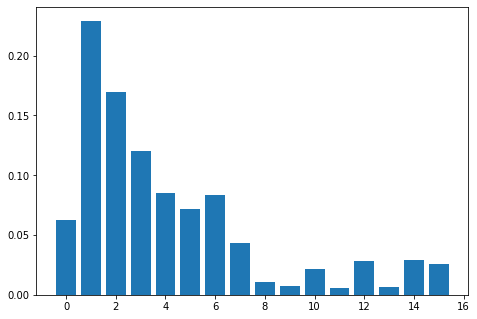

Time for epoch 62 is 9.844103336334229 sec


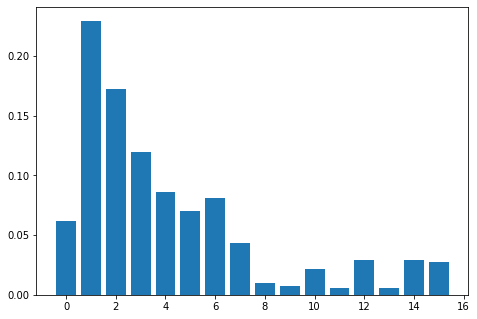

Time for epoch 63 is 9.938456773757935 sec


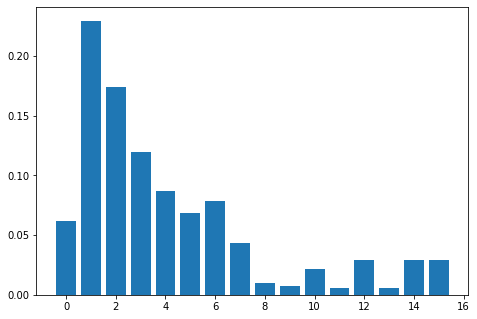

Time for epoch 64 is 9.848145723342896 sec


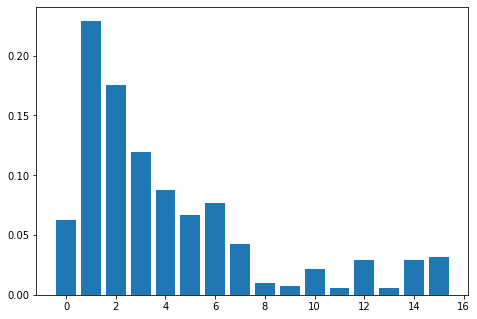

Time for epoch 65 is 9.852266550064087 sec


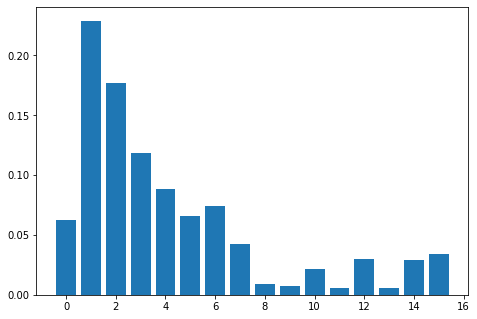

Time for epoch 66 is 9.931591272354126 sec


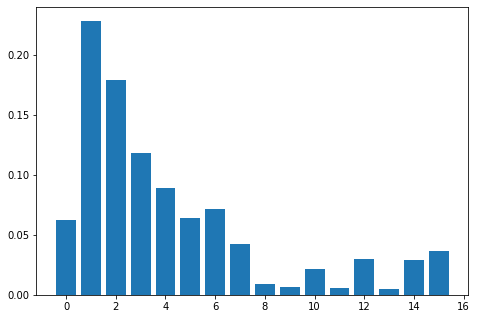

Time for epoch 67 is 9.915067195892334 sec


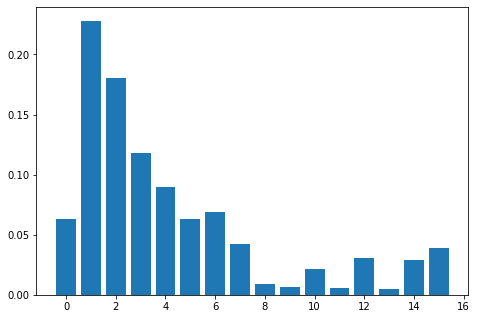

Time for epoch 68 is 9.876594066619873 sec


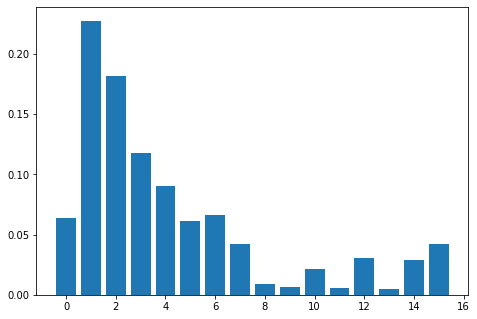

Time for epoch 69 is 9.81173825263977 sec


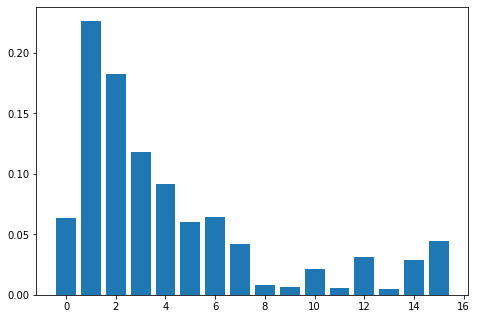

Time for epoch 70 is 9.72848391532898 sec


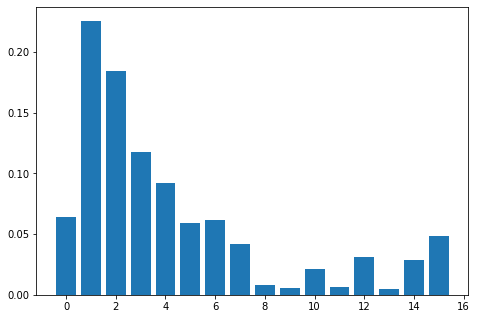

Time for epoch 71 is 9.909577369689941 sec


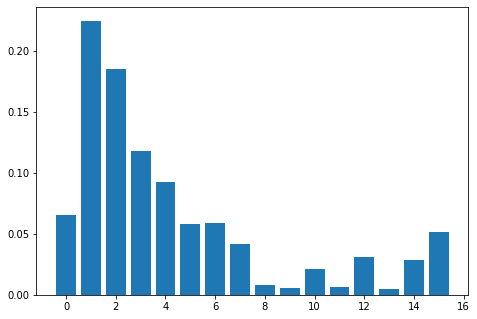

Time for epoch 72 is 9.777605772018433 sec


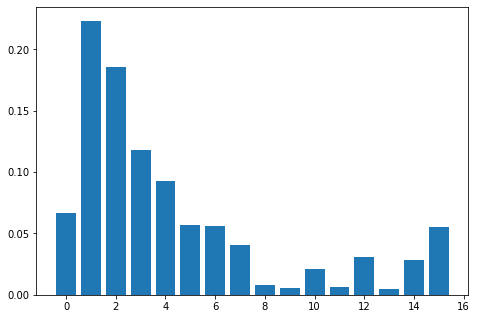

Time for epoch 73 is 9.830909729003906 sec


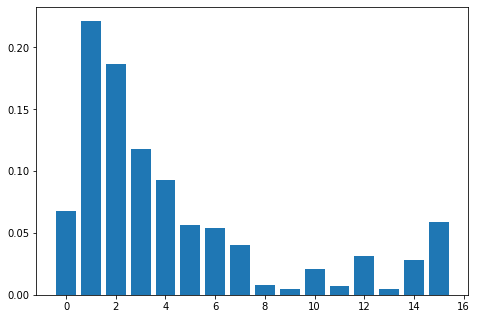

Time for epoch 74 is 9.793662786483765 sec


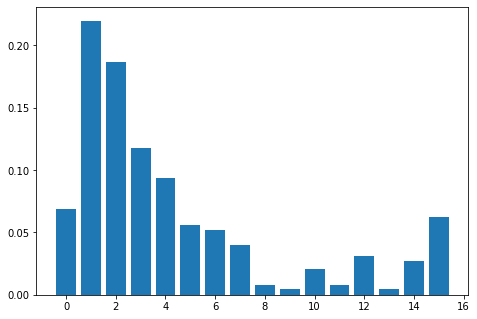

Time for epoch 75 is 9.783941507339478 sec


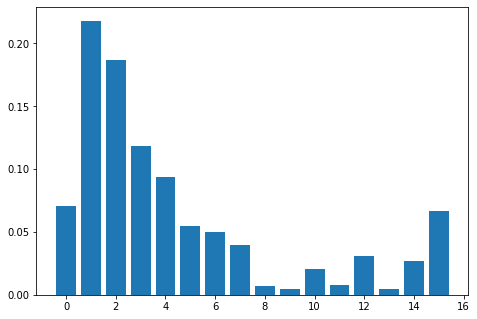

Time for epoch 76 is 10.047288656234741 sec


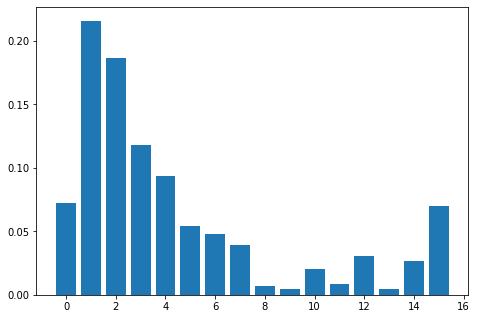

Time for epoch 77 is 9.778833389282227 sec


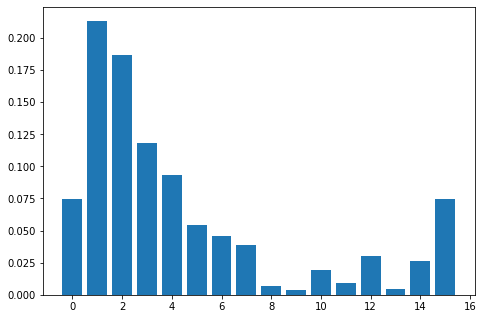

Time for epoch 78 is 9.879732131958008 sec


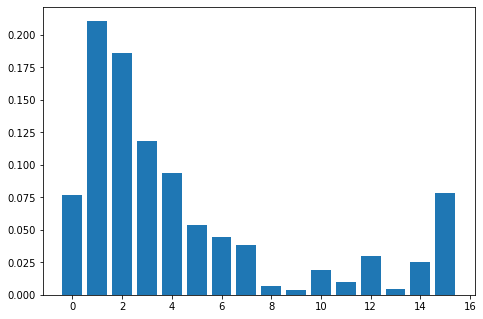

Time for epoch 79 is 9.709662675857544 sec


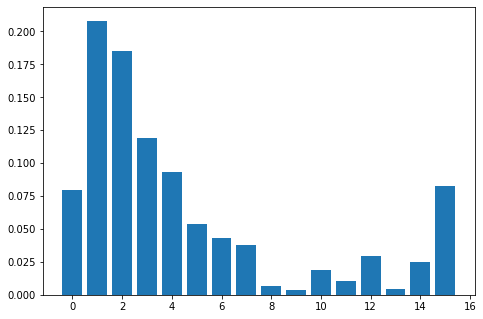

Time for epoch 80 is 9.773769855499268 sec


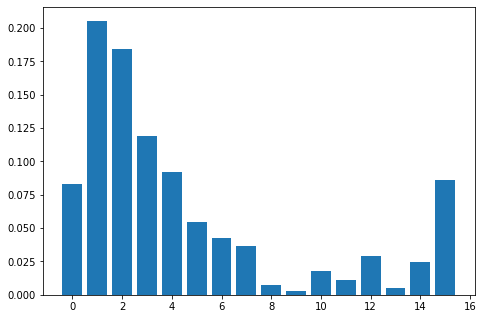

Time for epoch 81 is 9.765289783477783 sec


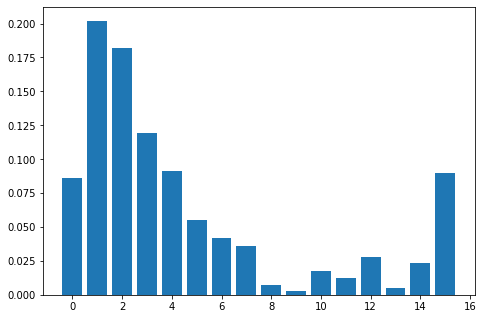

Time for epoch 82 is 9.75749158859253 sec


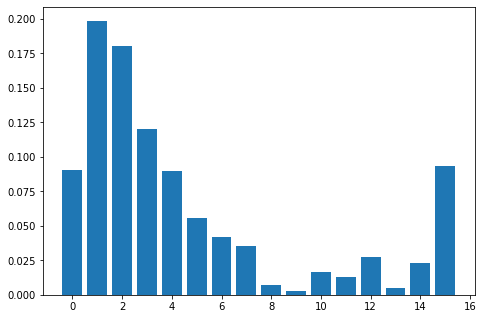

Time for epoch 83 is 9.875129461288452 sec


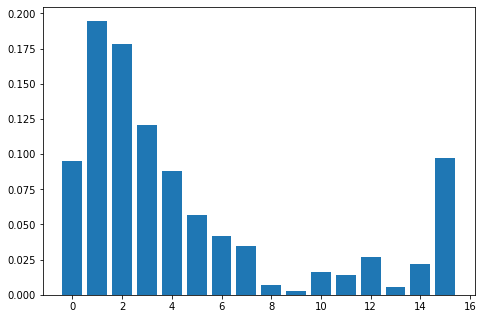

Time for epoch 84 is 9.873071908950806 sec


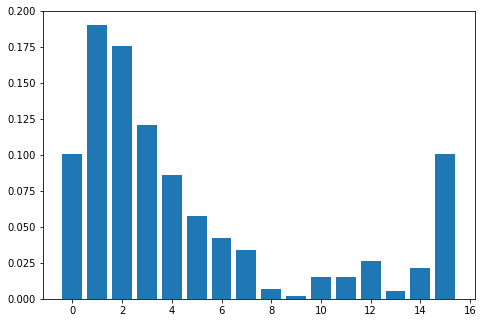

Time for epoch 85 is 9.73499870300293 sec


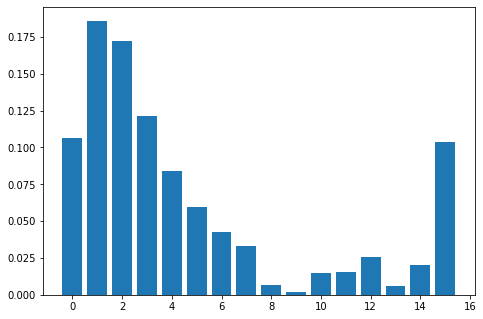

Time for epoch 86 is 9.965098857879639 sec


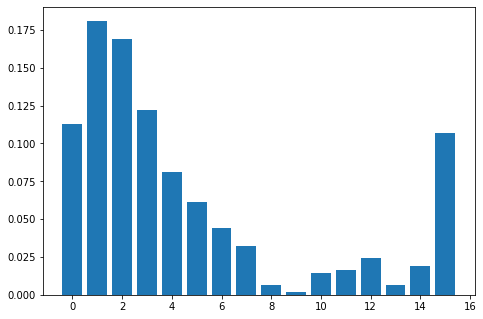

Time for epoch 87 is 9.825964212417603 sec


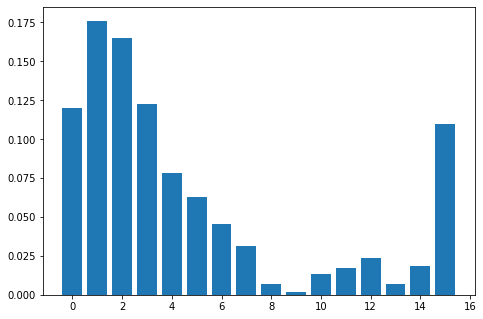

Time for epoch 88 is 9.869870662689209 sec


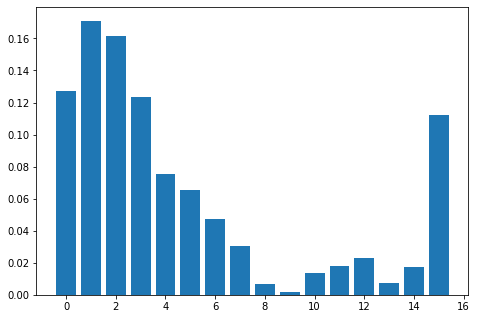

Time for epoch 89 is 9.950205087661743 sec


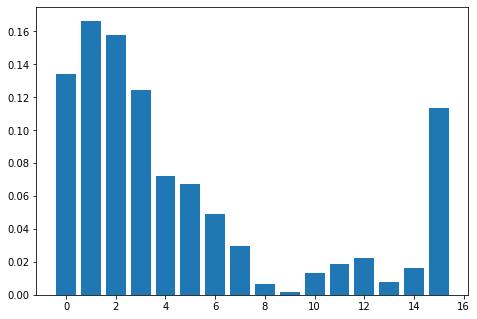

Time for epoch 90 is 9.794025659561157 sec


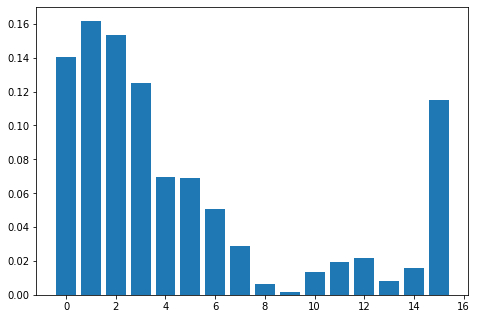

Time for epoch 91 is 9.852576971054077 sec


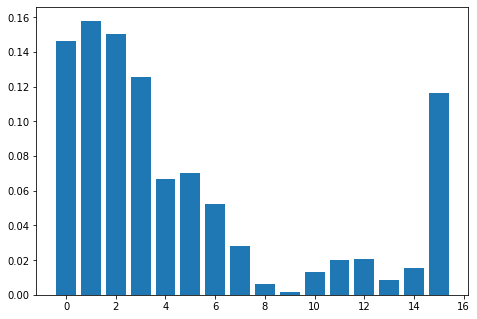

Time for epoch 92 is 9.821707487106323 sec


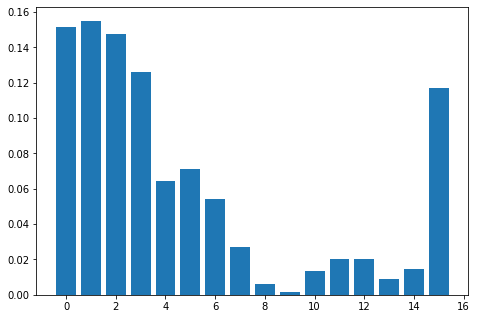

Time for epoch 93 is 9.997319221496582 sec


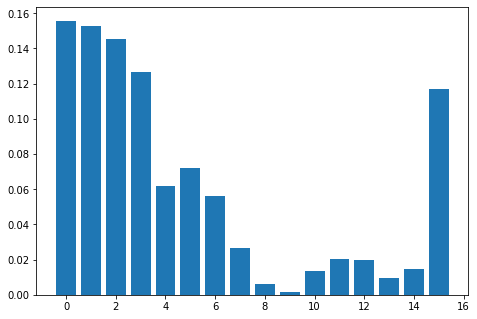

Time for epoch 94 is 9.924919605255127 sec


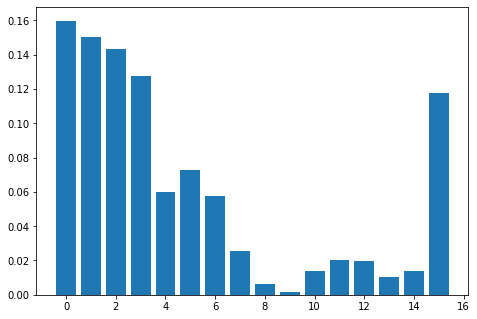

Time for epoch 95 is 9.860829830169678 sec


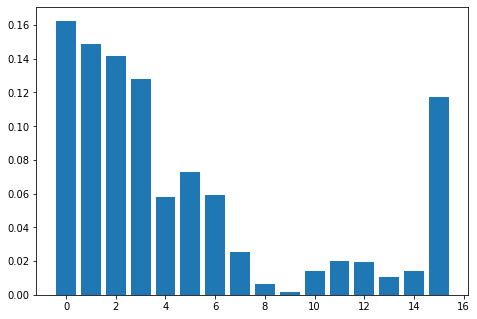

Time for epoch 96 is 10.000291347503662 sec


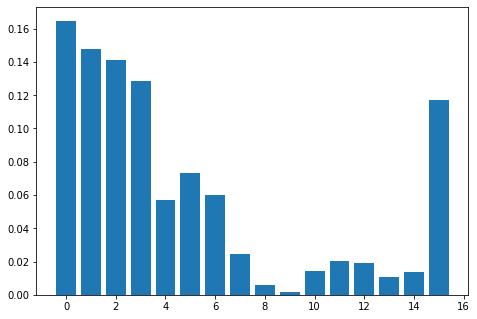

Time for epoch 97 is 9.903862714767456 sec


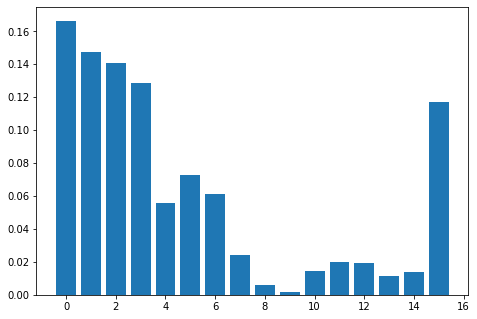

Time for epoch 98 is 9.761274099349976 sec


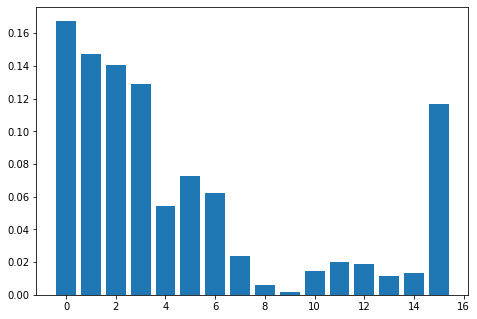

Time for epoch 99 is 9.958268165588379 sec


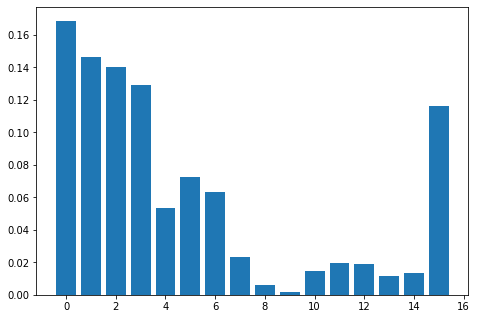

Time for epoch 100 is 9.859087228775024 sec


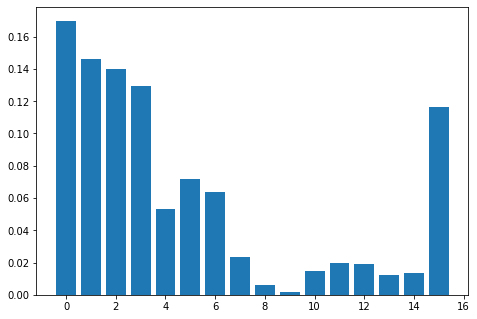

Time for epoch 101 is 9.787373304367065 sec


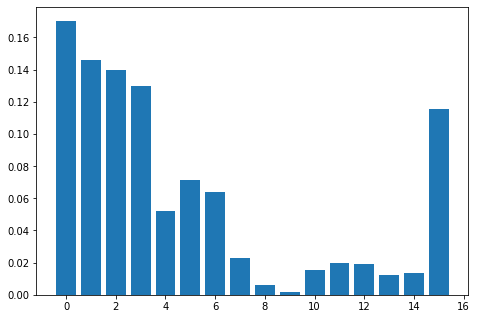

Time for epoch 102 is 9.784154891967773 sec


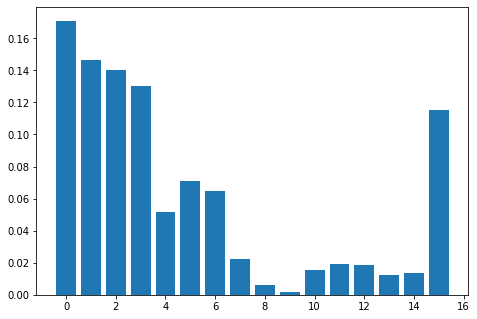

Time for epoch 103 is 9.814976692199707 sec


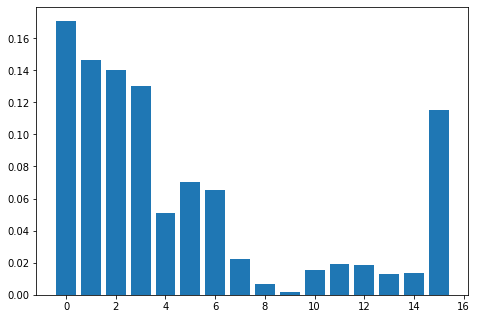

Time for epoch 104 is 9.954009532928467 sec


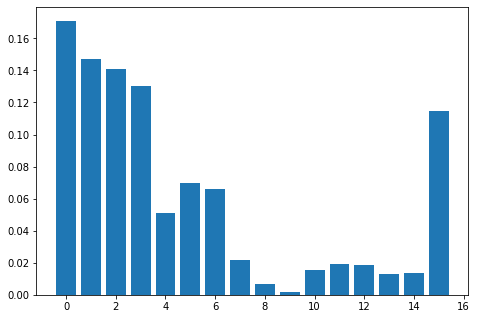

Time for epoch 105 is 9.8226478099823 sec


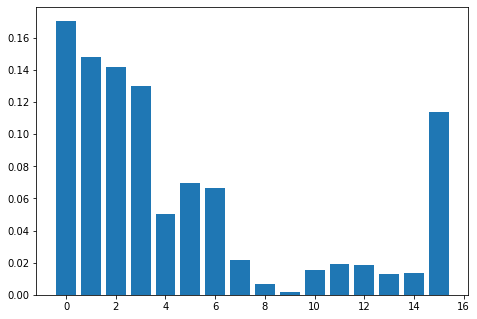

Time for epoch 106 is 10.03647780418396 sec


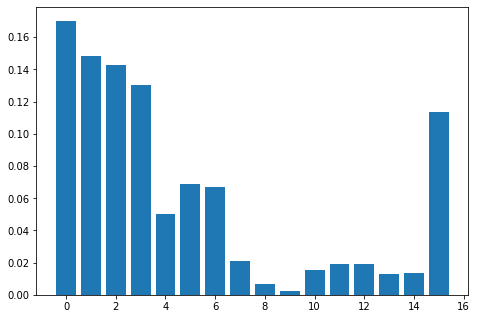

Time for epoch 107 is 9.788766622543335 sec


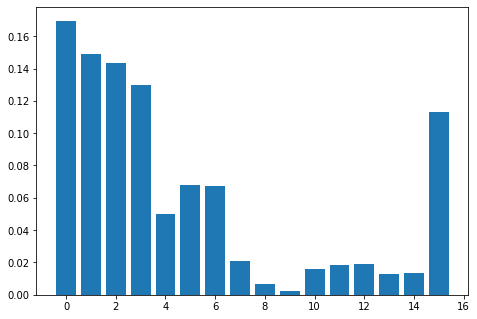

Time for epoch 108 is 10.1598539352417 sec


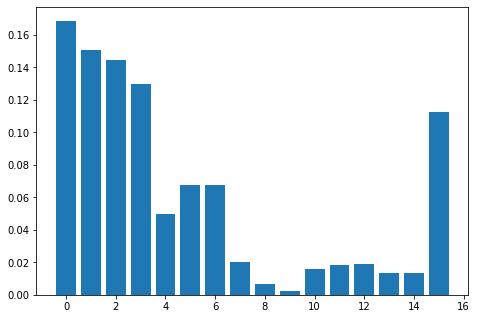

Time for epoch 109 is 9.757645606994629 sec


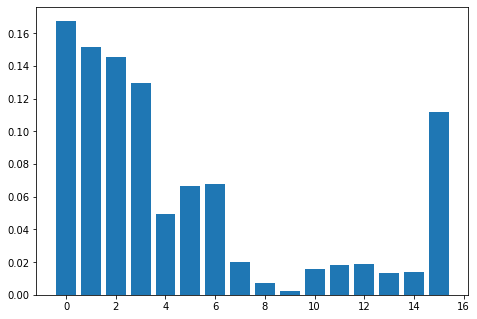

Time for epoch 110 is 9.845445156097412 sec


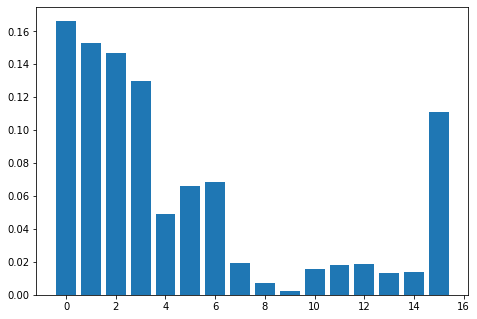

Time for epoch 111 is 9.872905969619751 sec


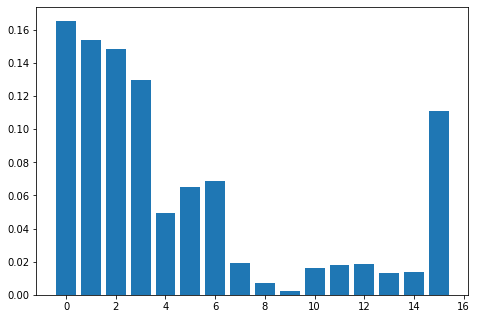

Time for epoch 112 is 10.004875659942627 sec


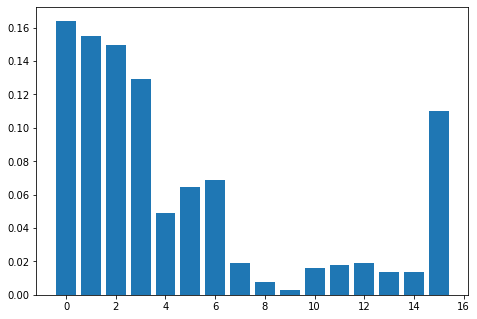

Time for epoch 113 is 9.968969106674194 sec


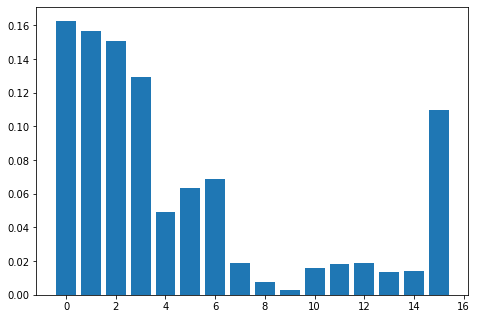

Time for epoch 114 is 10.033082246780396 sec


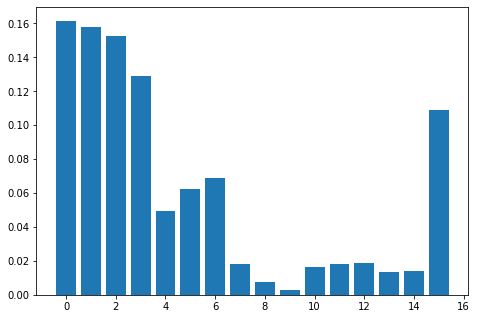

Time for epoch 115 is 10.17491602897644 sec


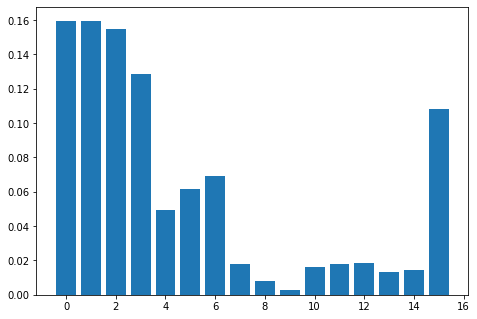

Time for epoch 116 is 9.993755578994751 sec


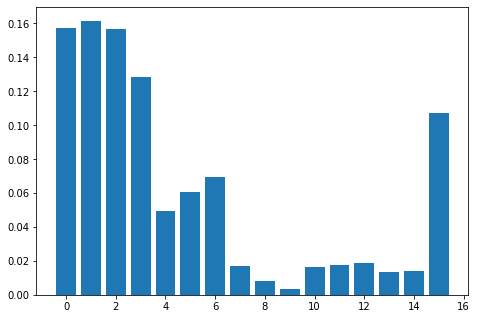

Time for epoch 117 is 10.050723314285278 sec


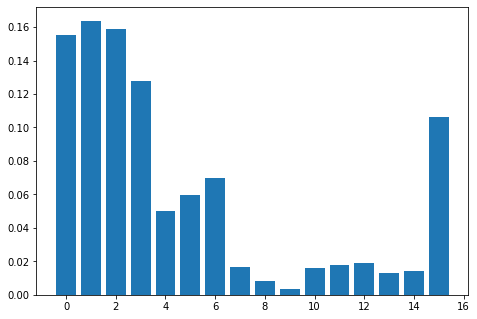

Time for epoch 118 is 10.049142599105835 sec


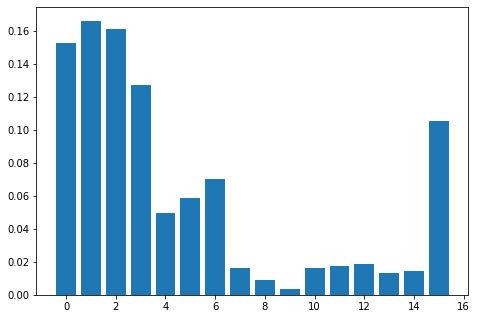

Time for epoch 119 is 9.946642637252808 sec


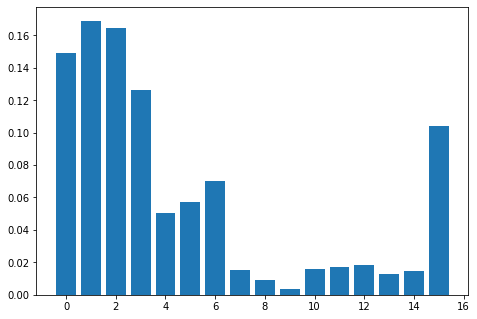

Time for epoch 120 is 9.97131872177124 sec


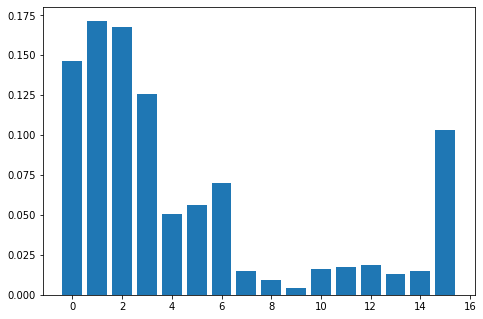

Time for epoch 121 is 9.832174301147461 sec


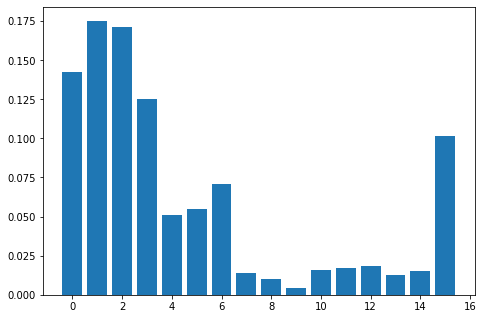

Time for epoch 122 is 9.875415563583374 sec


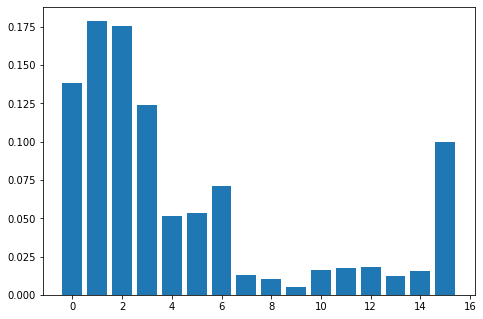

Time for epoch 123 is 9.813285112380981 sec


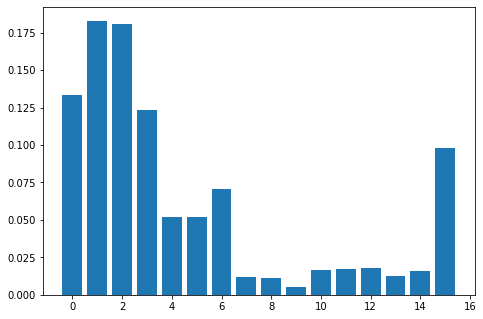

Time for epoch 124 is 9.778743505477905 sec


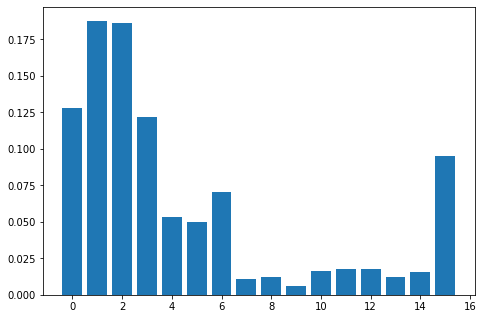

Time for epoch 125 is 9.778022050857544 sec


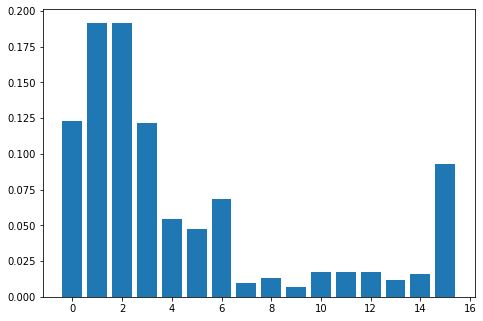

Time for epoch 126 is 9.710973262786865 sec


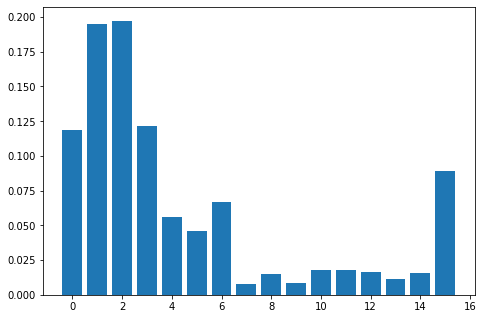

Time for epoch 127 is 9.691411256790161 sec


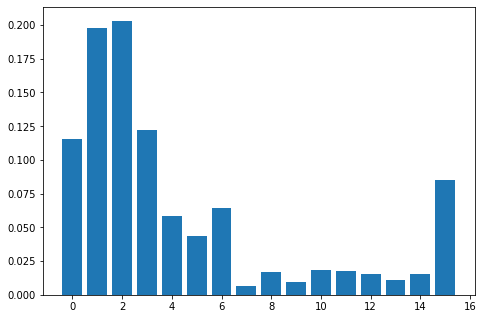

Time for epoch 128 is 9.7998628616333 sec


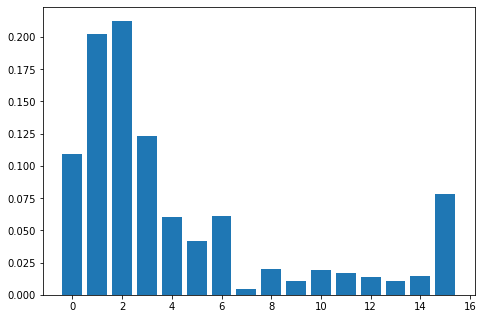

Time for epoch 129 is 9.593060970306396 sec


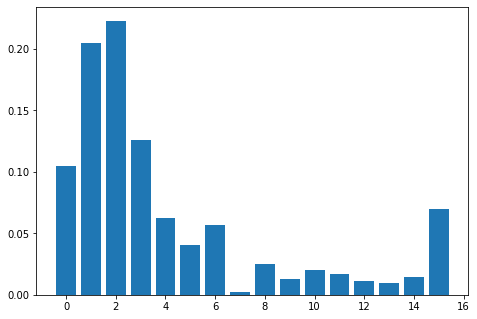

Time for epoch 130 is 9.66048002243042 sec


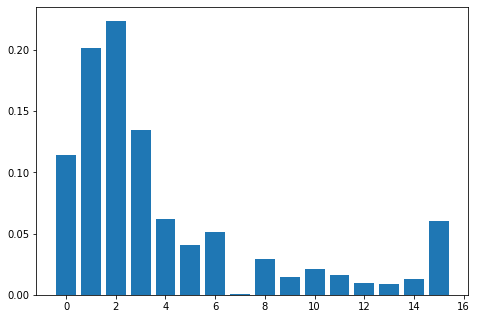

Time for epoch 131 is 10.011067867279053 sec


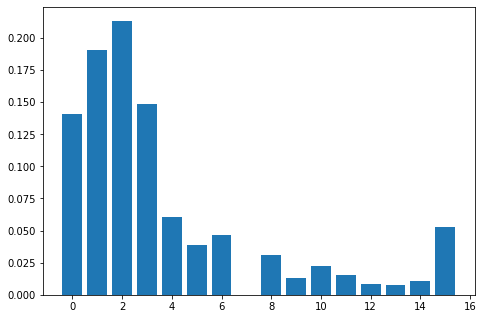

Time for epoch 132 is 9.673810720443726 sec


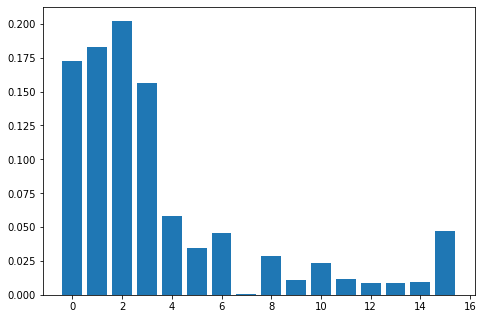

Time for epoch 133 is 9.82275128364563 sec


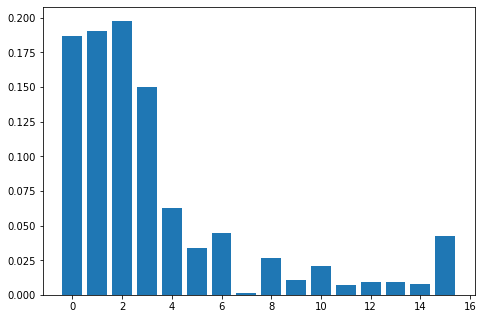

Time for epoch 134 is 9.766912937164307 sec


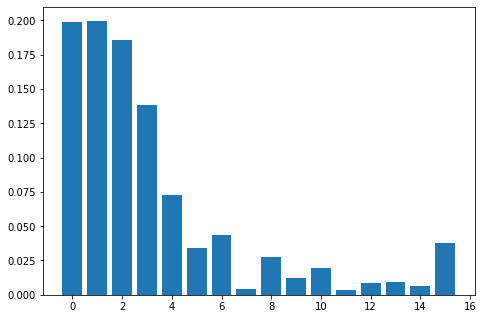

Time for epoch 135 is 9.742830991744995 sec


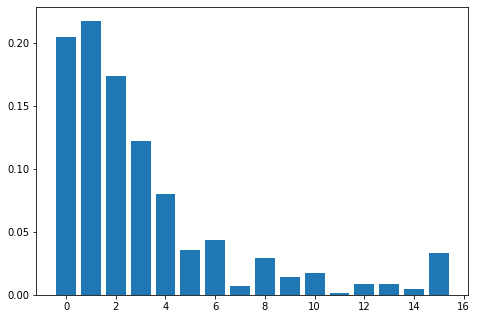

Time for epoch 136 is 9.760345458984375 sec


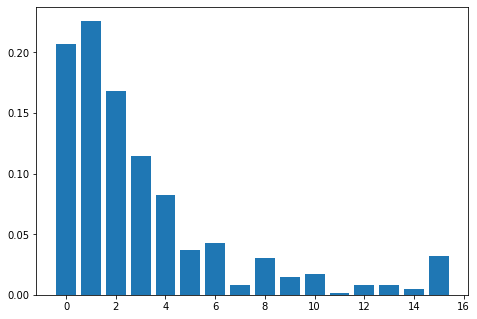

Time for epoch 137 is 9.969852685928345 sec


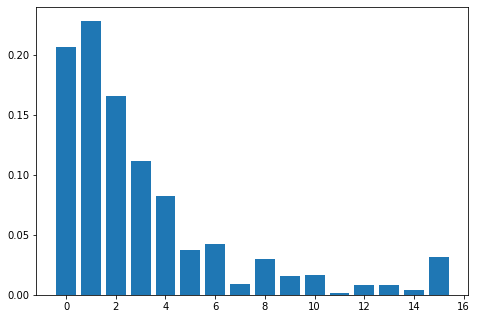

Time for epoch 138 is 10.044077634811401 sec


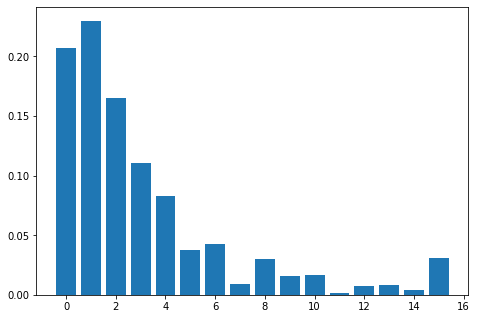

Time for epoch 139 is 9.926946878433228 sec


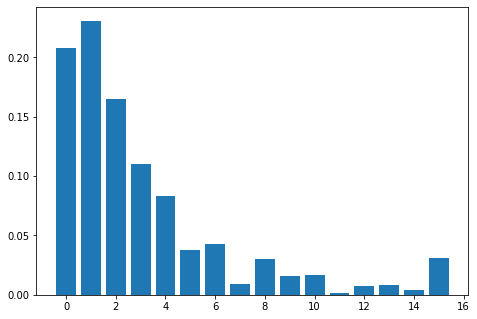

Time for epoch 140 is 9.913276195526123 sec


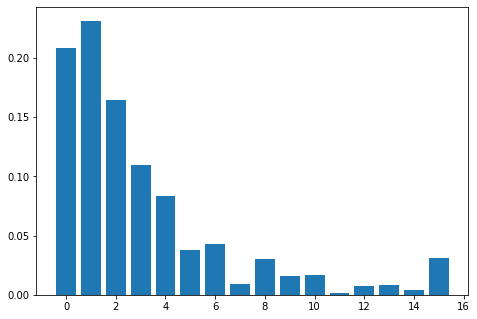

Time for epoch 141 is 10.038695096969604 sec


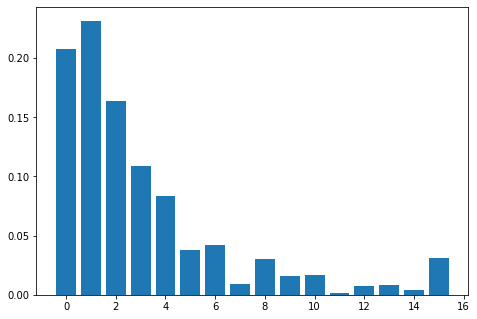

Time for epoch 142 is 9.84372615814209 sec


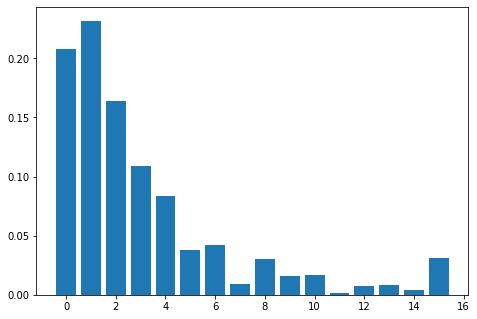

Time for epoch 143 is 9.830141544342041 sec


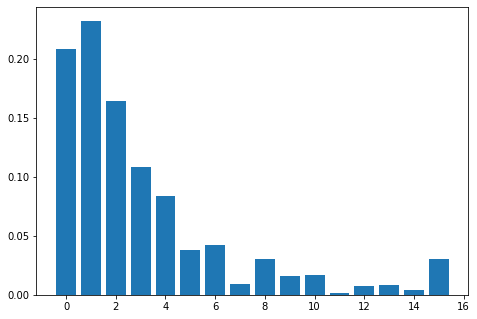

Time for epoch 144 is 9.861945867538452 sec


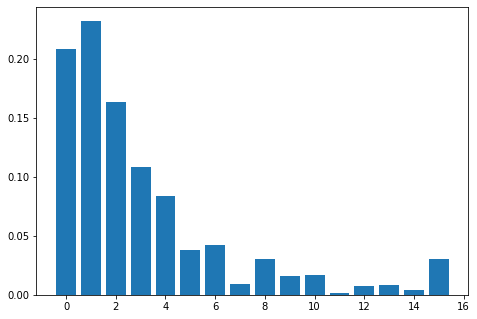

Time for epoch 145 is 9.781691551208496 sec


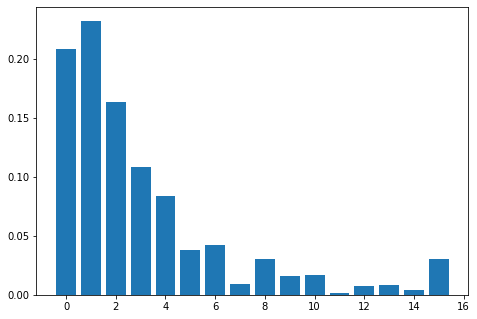

Time for epoch 146 is 9.929355144500732 sec


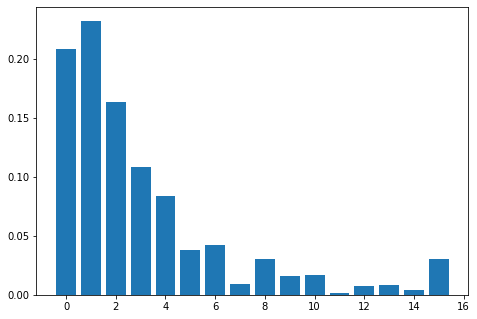

Time for epoch 147 is 9.812581539154053 sec


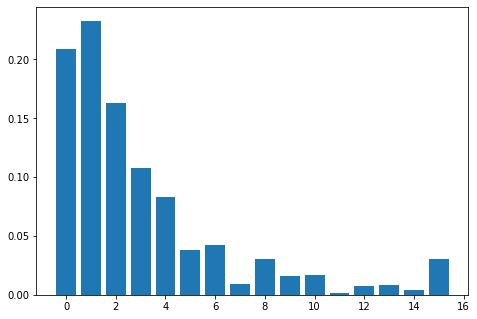

Time for epoch 148 is 9.783914804458618 sec


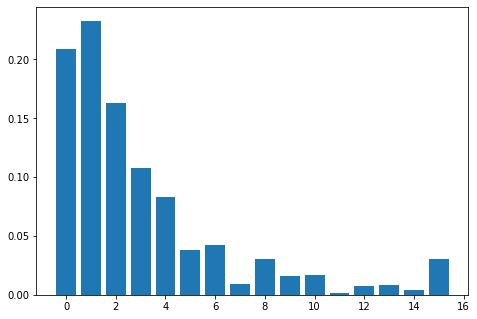

Time for epoch 149 is 9.848095417022705 sec


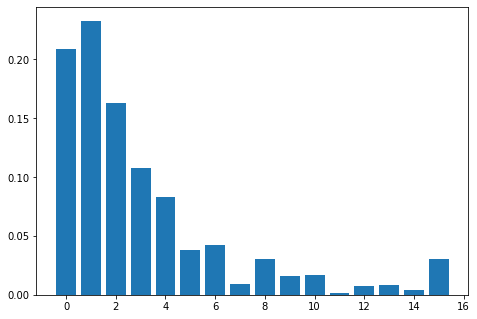

Time for epoch 150 is 9.915523052215576 sec


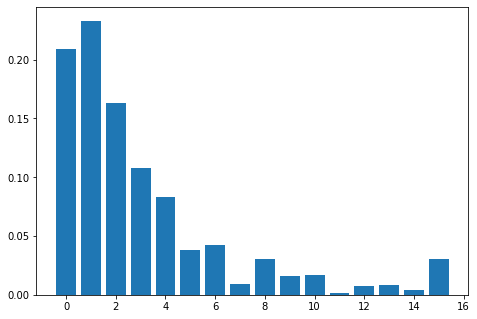

Time for epoch 151 is 9.804341793060303 sec


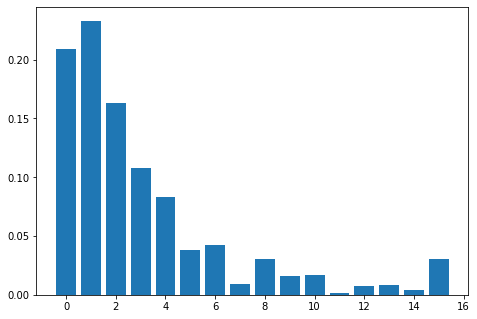

Time for epoch 152 is 9.730969667434692 sec


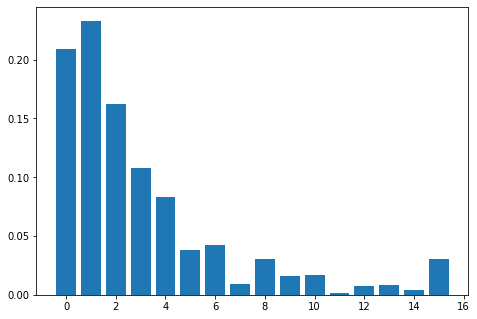

Time for epoch 153 is 9.744323492050171 sec


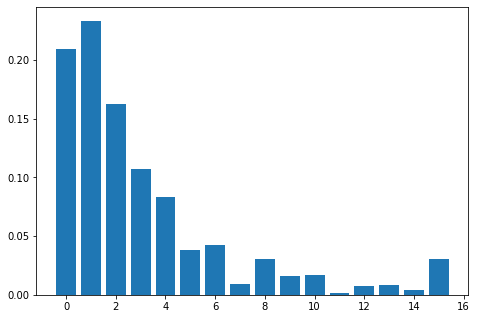

Time for epoch 154 is 9.708524227142334 sec


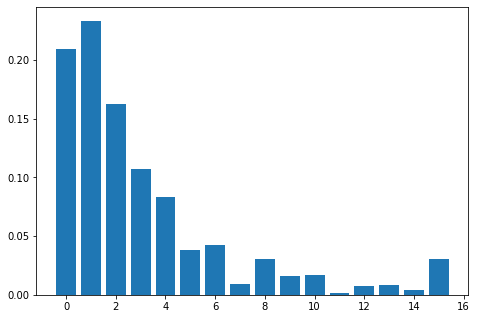

Time for epoch 155 is 9.680495500564575 sec


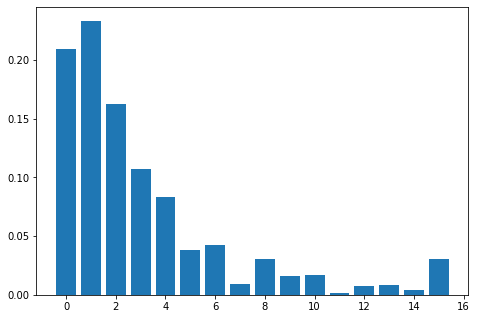

Time for epoch 156 is 9.811450242996216 sec


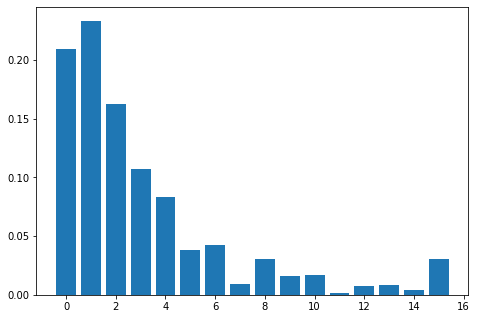

Time for epoch 157 is 9.763252019882202 sec


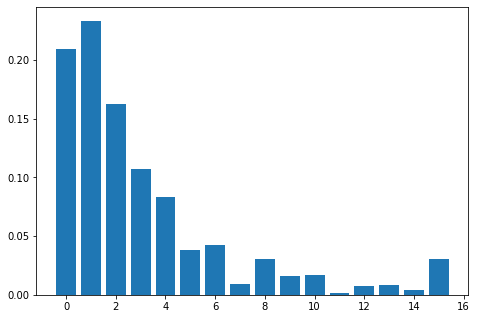

Time for epoch 158 is 9.54409646987915 sec


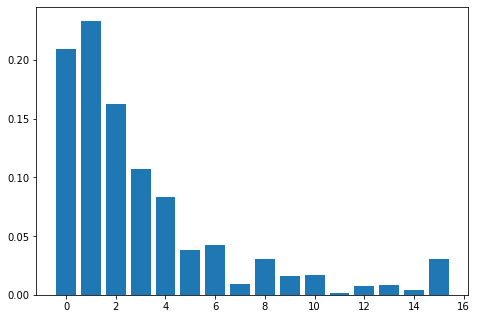

Time for epoch 159 is 9.55597972869873 sec


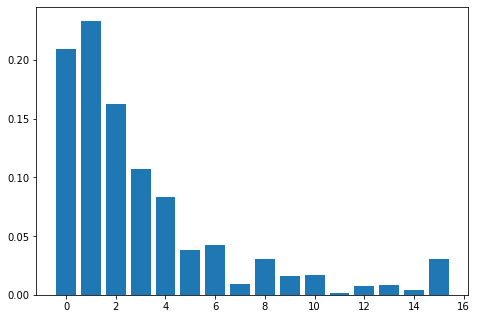

Time for epoch 160 is 9.594855070114136 sec


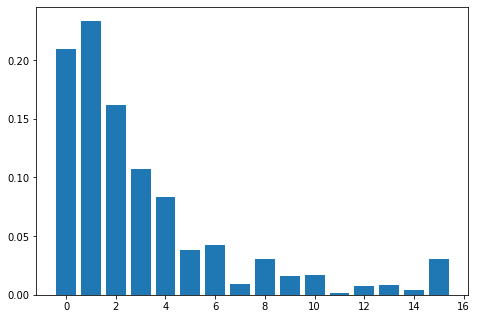

Time for epoch 161 is 9.691847562789917 sec


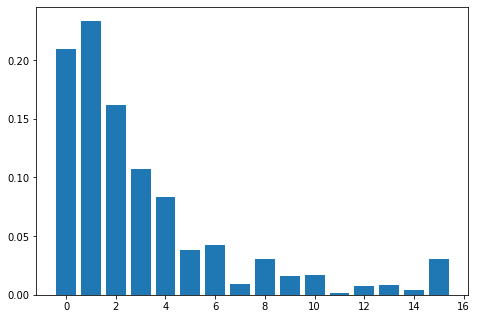

Time for epoch 162 is 9.71057391166687 sec


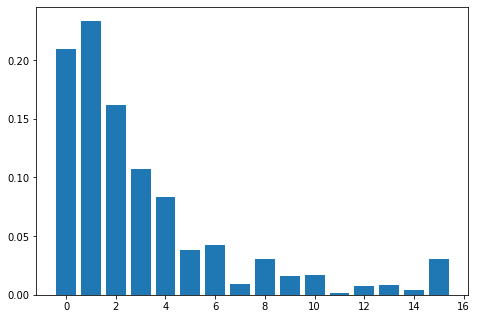

Time for epoch 163 is 10.196748495101929 sec


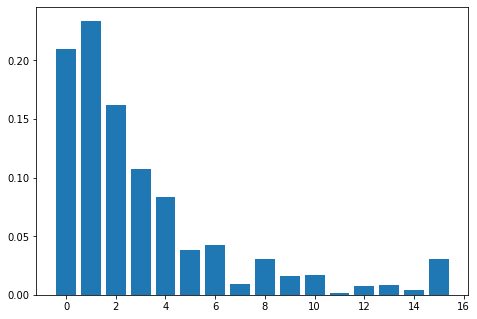

Time for epoch 164 is 9.639936208724976 sec


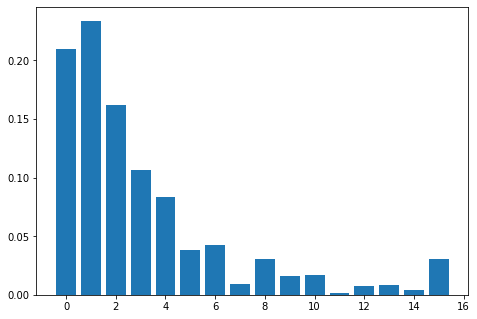

Time for epoch 165 is 9.611164093017578 sec


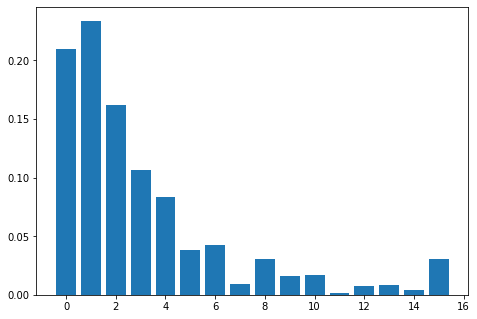

Time for epoch 166 is 9.530931234359741 sec


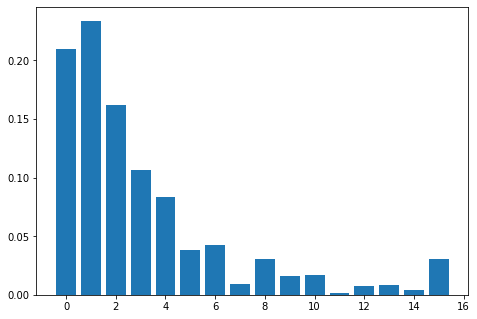

Time for epoch 167 is 9.706103324890137 sec


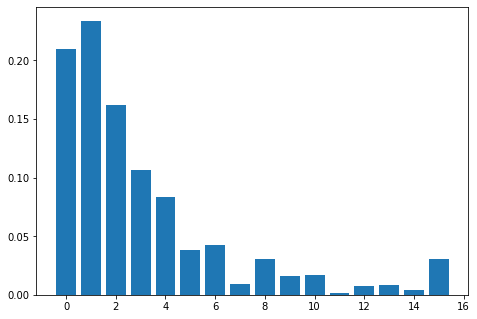

Time for epoch 168 is 9.682065725326538 sec


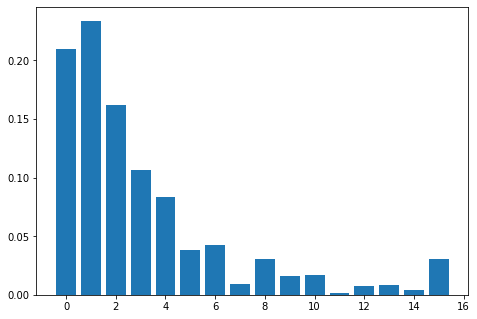

Time for epoch 169 is 9.631251573562622 sec


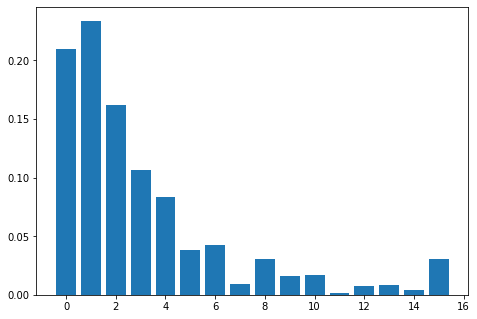

Time for epoch 170 is 9.722913026809692 sec


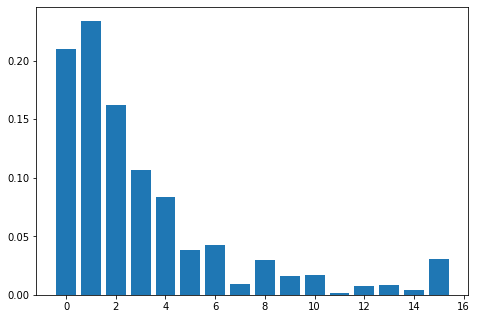

Time for epoch 171 is 9.684685468673706 sec


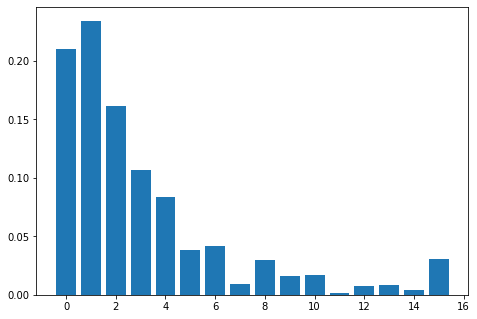

Time for epoch 172 is 9.856710433959961 sec


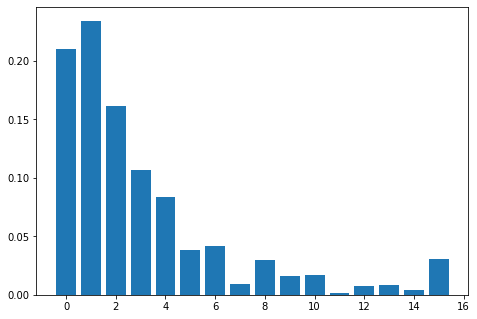

Time for epoch 173 is 9.860001802444458 sec


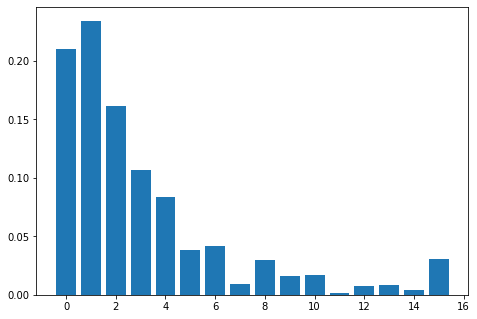

Time for epoch 174 is 9.792802572250366 sec


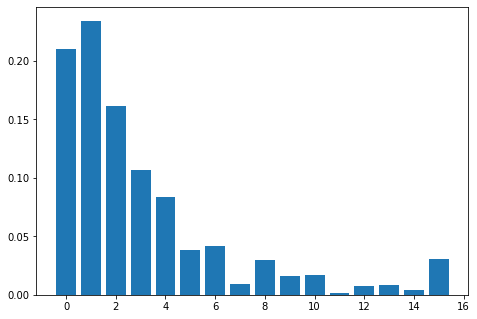

Time for epoch 175 is 9.763458728790283 sec


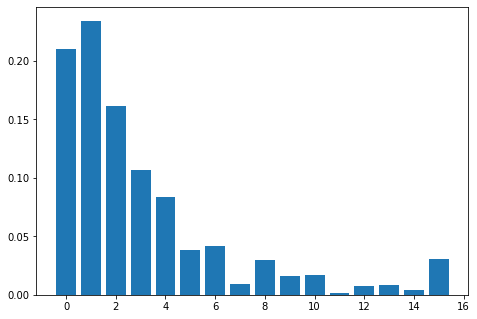

Time for epoch 176 is 9.961126565933228 sec


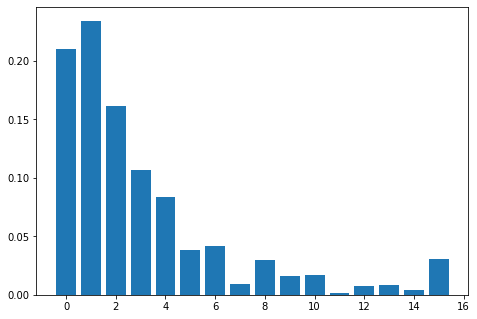

Time for epoch 177 is 9.97696828842163 sec


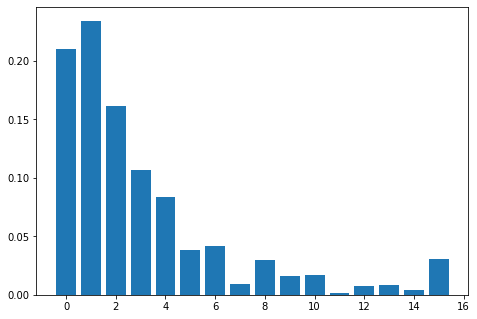

Time for epoch 178 is 9.708219528198242 sec


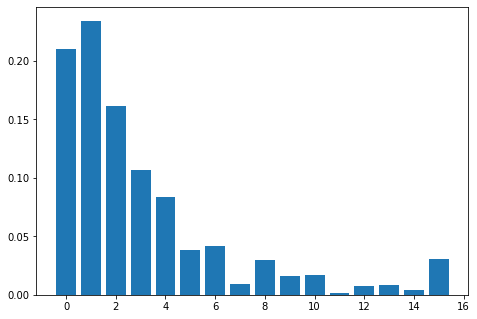

Time for epoch 179 is 9.828871011734009 sec


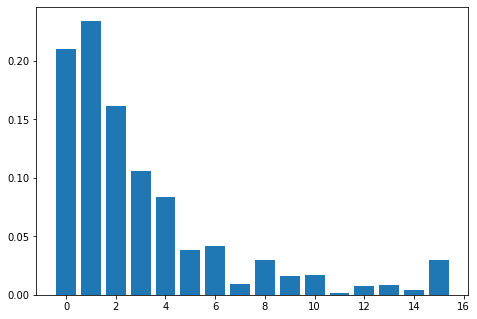

Time for epoch 180 is 9.90539002418518 sec


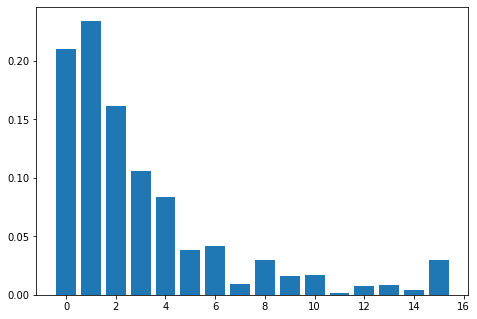

Time for epoch 181 is 9.929523706436157 sec


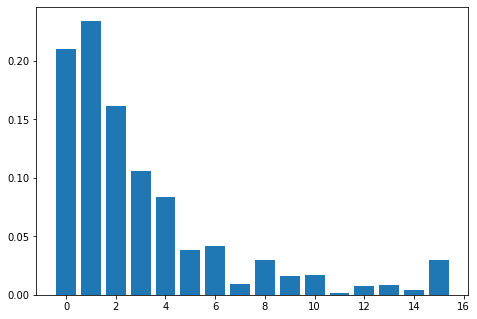

Time for epoch 182 is 9.764751672744751 sec


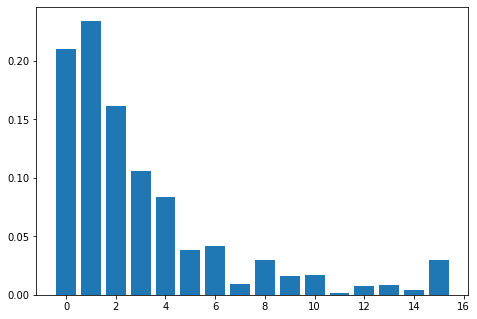

Time for epoch 183 is 9.617200136184692 sec


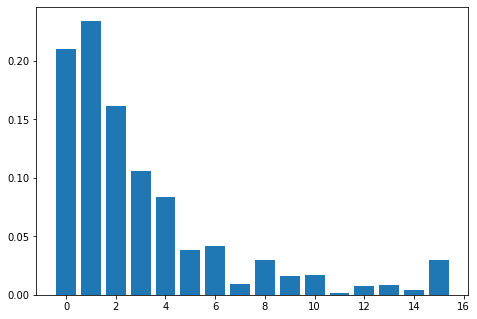

Time for epoch 184 is 9.709212303161621 sec


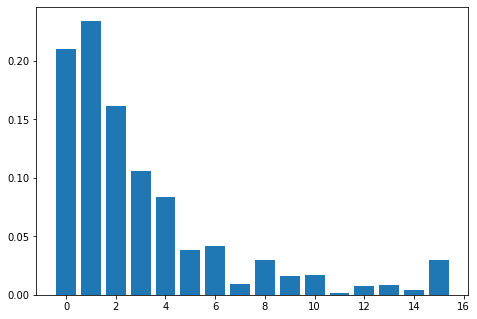

Time for epoch 185 is 9.850478649139404 sec


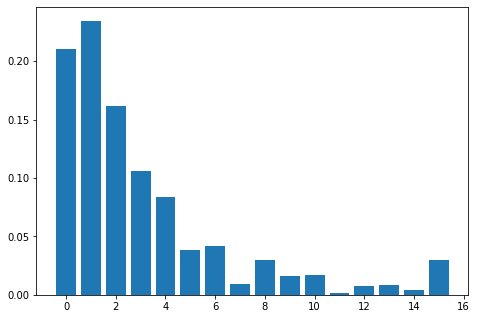

Time for epoch 186 is 9.627555847167969 sec


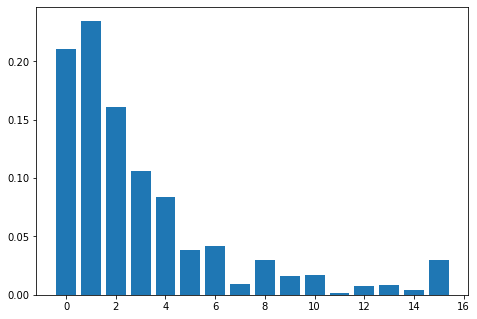

Time for epoch 187 is 9.64283013343811 sec


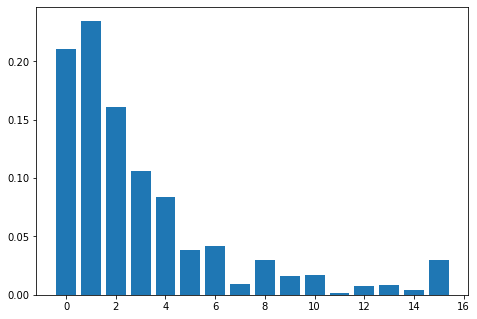

Time for epoch 188 is 9.64374828338623 sec


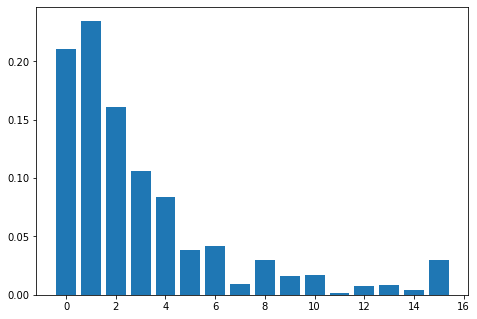

Time for epoch 189 is 9.643454551696777 sec


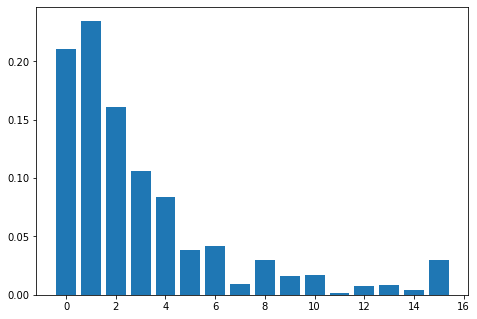

Time for epoch 190 is 10.125733852386475 sec


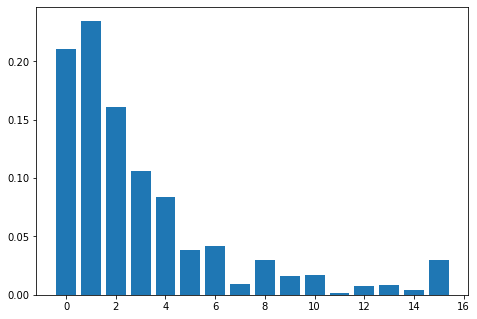

Time for epoch 191 is 10.531497478485107 sec


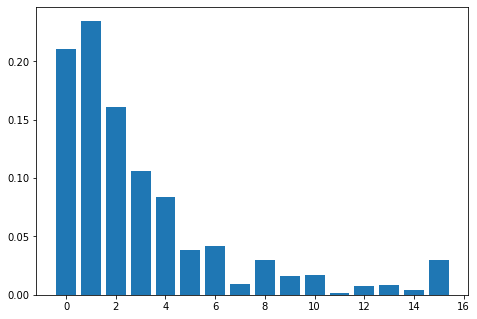

Time for epoch 192 is 10.81189227104187 sec


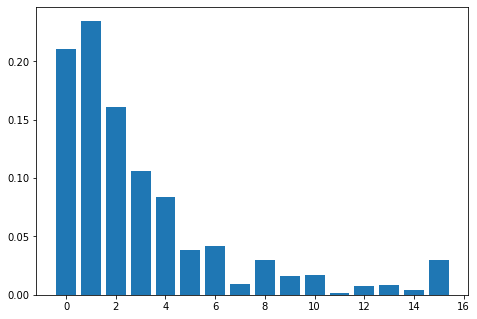

Time for epoch 193 is 11.490756034851074 sec


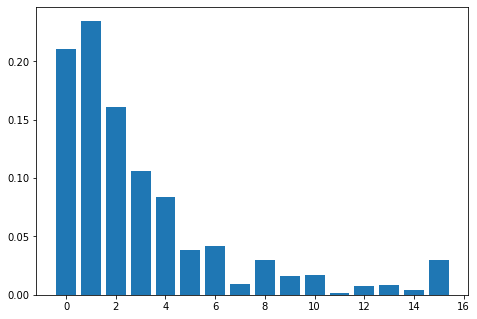

Time for epoch 194 is 9.852254152297974 sec


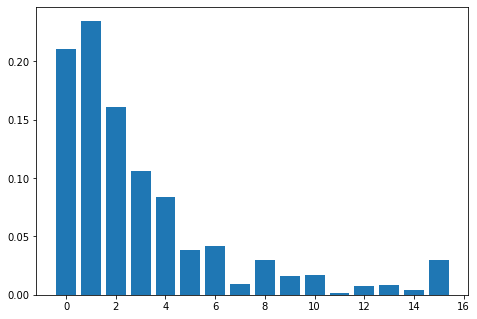

Time for epoch 195 is 10.395568609237671 sec


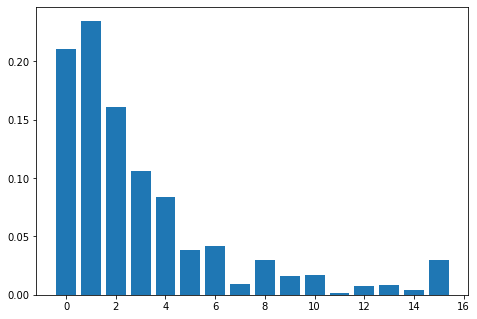

Time for epoch 196 is 10.163493156433105 sec


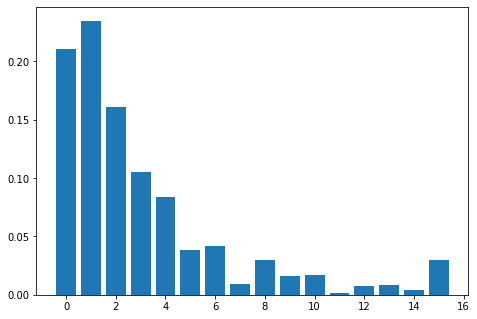

Time for epoch 197 is 9.92566180229187 sec


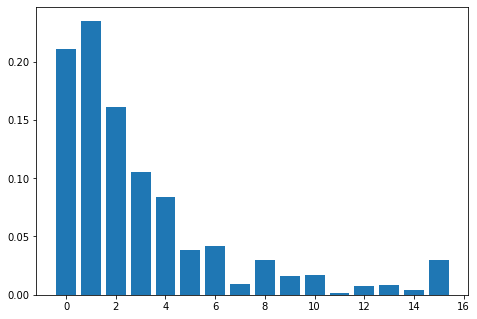

Time for epoch 198 is 10.33916711807251 sec


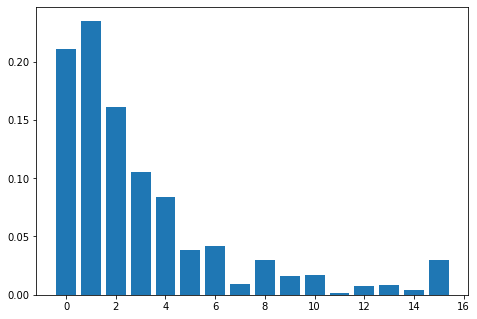

Time for epoch 199 is 9.998679637908936 sec


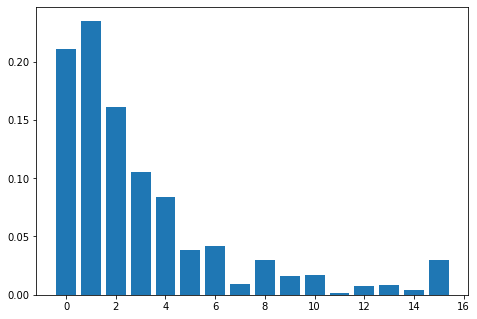

Time for epoch 200 is 9.755571603775024 sec


In [28]:
train(data_loader, EPOCHS)

In [29]:
noise = tf.random.normal([1, 4])
generated_data = generator(noise, training=False).numpy()
generated_data

array([[0.21101413, 0.23522173, 0.16071197, 0.10556106, 0.08353673,
        0.03867675, 0.04199435, 0.00939102, 0.03008208, 0.01651171,
        0.01656735, 0.00144916, 0.00719761, 0.00805196, 0.00401909,
        0.03001332]])

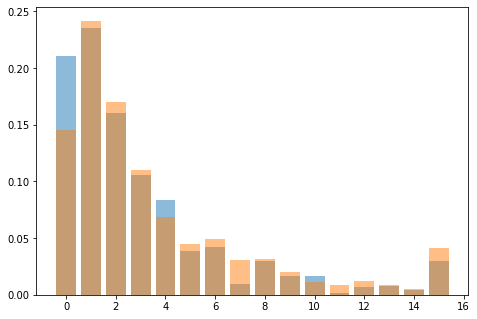

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, generated_data[0], alpha=0.5)
ax.bar(y, new_point, alpha=0.5)
plt.show()

In [31]:
generator.weights

[<tf.Variable 'sequential/keras_layer/weights:0' shape=(36, 1) dtype=float32, numpy=
 array([[-2.34678596e-01],
        [ 5.76599717e-01],
        [ 1.13615358e+00],
        [ 7.60884047e-01],
        [ 5.66751719e-01],
        [ 1.02041471e+00],
        [ 1.15204167e+00],
        [ 1.12568438e+00],
        [ 4.01003063e-02],
        [ 7.18806446e-01],
        [ 9.55563724e-01],
        [-9.81838524e-01],
        [-1.56514738e-02],
        [ 2.00070366e-01],
        [ 1.35257505e-02],
        [ 9.13787931e-02],
        [-1.14291930e+00],
        [-4.21481758e-01],
        [ 1.20227897e+00],
        [ 4.54372436e-01],
        [ 1.35663843e+00],
        [-1.11526871e+00],
        [ 8.60125124e-01],
        [ 3.90946001e-01],
        [-9.39617574e-01],
        [ 2.91445732e-01],
        [-1.10212374e+00],
        [ 3.83200824e-01],
        [-5.31050384e-01],
        [-3.78515512e-01],
        [-3.39532822e-01],
        [-1.89296648e-01],
        [ 1.74450457e-01],
        [-1.24228001e-03